In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

BASE_URL = "https://icelec50015.azurewebsites.net"
ENDPOINTS = {
    "price": "/price",
    "yesterday": "/yesterday"
}

def fetch_day_data():
    url = BASE_URL + ENDPOINTS["yesterday"]
    response = requests.get(url)
    return pd.DataFrame(response.json())

In [3]:
day_spans = [1, 1000]
all_avg_buy = []
all_avg_sell = []

for days in day_spans:
    buy_prices = []
    sell_prices = []
    for _ in range(days):
        df = fetch_day_data()
        buy_prices.append(df['buy_price'].values)
        sell_prices.append(df['sell_price'].values)
    buy_prices = np.array(buy_prices)
    sell_prices = np.array(sell_prices)
    avg_buy = buy_prices.mean(axis=0)
    avg_sell = sell_prices.mean(axis=0)
    all_avg_buy.append(avg_buy)
    all_avg_sell.append(avg_sell)

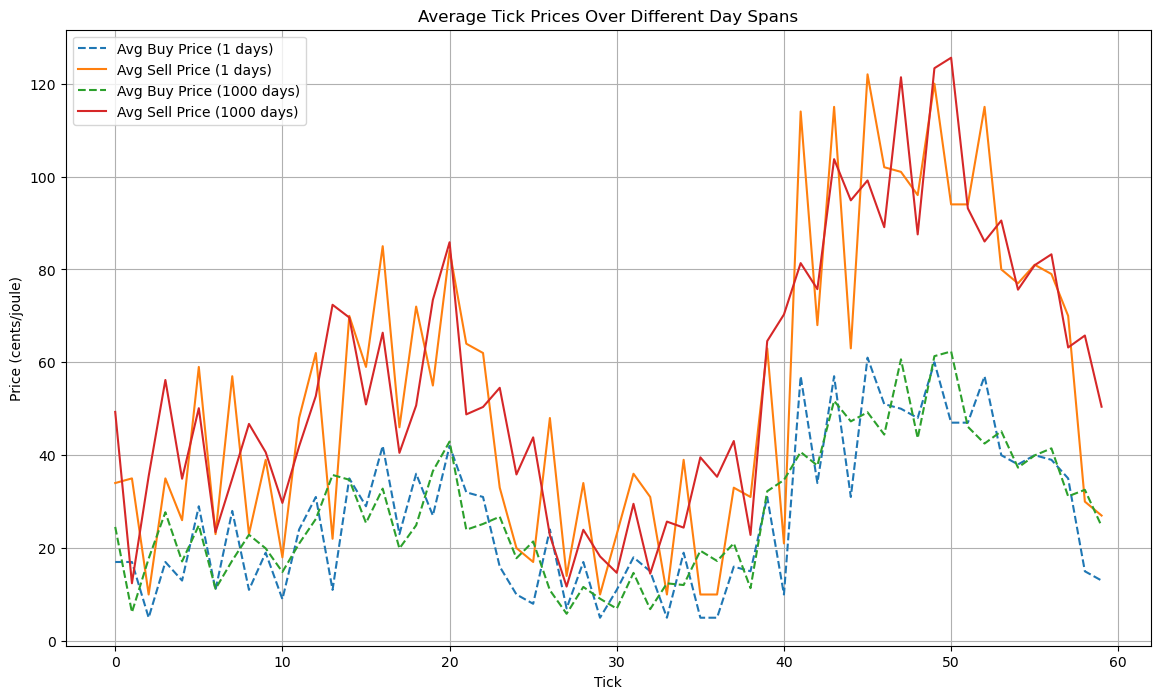

In [4]:
plt.figure(figsize=(14, 8))
for i, days in enumerate(day_spans):
    plt.plot(all_avg_buy[i], label=f'Avg Buy Price ({days} days)', linestyle='--')
    plt.plot(all_avg_sell[i], label=f'Avg Sell Price ({days} days)')
plt.xlabel('Tick')
plt.ylabel('Price (cents/joule)')
plt.title('Average Tick Prices Over Different Day Spans')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# 4. Save Aggregated Tick Price Statistics for Each Time Span
os.makedirs('tick_price_stats', exist_ok=True)

for i, days in enumerate(day_spans):
    df = pd.DataFrame({
        'avg_buy_price': all_avg_buy[i],
        'avg_sell_price': all_avg_sell[i]
    })
    df.to_csv(f'tick_price_stats/avg_tick_prices_{days}d.csv', index_label='tick')
print("Aggregated tick price statistics saved to 'tick_price_stats/' directory.")

Aggregated tick price statistics saved to 'tick_price_stats/' directory.


## 4. Feature Engineering and Target Variable Selection

- Example features: moving averages, price volatility, price differentials, time-of-day, etc.
- Example targets: next tick buy/sell price, price movement direction, optimal trading action.

Below is a template for feature engineering using the 1000-day aggregated data.

In [6]:
# Example: Feature engineering on 1000-day aggregated data
# Use the correct index for 1000-day data (should be all_avg_buy[1] and all_avg_sell[1])
df_agg = pd.DataFrame({
    'avg_buy_price': all_avg_buy[1],
    'avg_sell_price': all_avg_sell[1]
})
# Moving averages (window=5 and window=20)
df_agg['buy_ma5'] = df_agg['avg_buy_price'].rolling(window=5, min_periods=1).mean()
df_agg['sell_ma5'] = df_agg['avg_sell_price'].rolling(window=5, min_periods=1).mean()
df_agg['buy_ma20'] = df_agg['avg_buy_price'].rolling(window=20, min_periods=1).mean()
df_agg['sell_ma20'] = df_agg['avg_sell_price'].rolling(window=20, min_periods=1).mean()
# Price differential and volatility
df_agg['price_diff'] = df_agg['avg_sell_price'] - df_agg['avg_buy_price']
df_agg['buy_volatility'] = df_agg['avg_buy_price'].rolling(window=10, min_periods=1).std().fillna(0)
df_agg['sell_volatility'] = df_agg['avg_sell_price'].rolling(window=10, min_periods=1).std().fillna(0)
# Target: next tick buy price and price movement direction
df_agg['target_next_buy'] = df_agg['avg_buy_price'].shift(-1)
df_agg['target_buy_up'] = (df_agg['target_next_buy'] > df_agg['avg_buy_price']).astype(int)
df_agg.head()

,avg_buy_price,avg_sell_price,buy_ma5,sell_ma5,buy_ma20,sell_ma20,price_diff,buy_volatility,sell_volatility,target_next_buy,target_buy_up
0,24.549,49.318,24.54900,49.318000,24.54900,49.318000,24.769,0.000000,0.000000,6.164,0
1,6.164,12.425,15.35650,30.871500,15.35650,30.871500,6.261,13.000158,26.087290,17.734,1
2,17.734,35.468,16.14900,32.403667,16.14900,32.403667,17.734,9.294419,18.636415,27.708,1
3,27.708,56.196,19.03875,38.351750,19.03875,38.351750,28.488,9.539048,19.314833,17.121,0
4,17.121,34.925,18.65520,37.666400,18.65520,37.666400,17.804,8.305458,16.797190,24.902,1


In [7]:
# Example: Adding sunshine, demand, and profit features (template)
# Replace the following with actual data sources if available
# For demonstration, we'll use random data with the same length as avg_buy_price
np.random.seed(42)
df_agg['sunshine'] = np.random.uniform(0, 1, size=len(df_agg))  # Replace with real sunshine data if available
df_agg['demand'] = np.random.normal(0.5, 0.1, size=len(df_agg))  # Replace with real demand data if available
# Moving averages for sunshine and demand
df_agg['sunshine_ma5'] = df_agg['sunshine'].rolling(window=5, min_periods=1).mean()
df_agg['demand_ma5'] = df_agg['demand'].rolling(window=5, min_periods=1).mean()
# Simulated profit (for demonstration, use your own profit calculation if available)
df_agg['simulated_profit'] = (df_agg['avg_sell_price'] - df_agg['avg_buy_price']).cumsum()
# Target: next tick demand and profit
df_agg['target_next_demand'] = df_agg['demand'].shift(-1)
df_agg['target_next_profit'] = df_agg['simulated_profit'].shift(-1)
df_agg.head()

,avg_buy_price,avg_sell_price,buy_ma5,sell_ma5,buy_ma20,sell_ma20,price_diff,buy_volatility,sell_volatility,target_next_buy,target_buy_up,sunshine,demand,sunshine_ma5,demand_ma5,simulated_profit,target_next_demand,target_next_profit
0,24.549,49.318,24.54900,49.318000,24.54900,49.318000,24.769,0.000000,0.000000,6.164,0,0.374540,0.352148,0.374540,0.352148,24.769,0.428016,31.030
1,6.164,12.425,15.35650,30.871500,15.35650,30.871500,6.261,13.000158,26.087290,17.734,1,0.950714,0.428016,0.662627,0.390082,31.030,0.453936,48.764
2,17.734,35.468,16.14900,32.403667,16.14900,32.403667,17.734,9.294419,18.636415,27.708,1,0.731994,0.453936,0.685749,0.411367,48.764,0.605712,77.252
3,27.708,56.196,19.03875,38.351750,19.03875,38.351750,28.488,9.539048,19.314833,17.121,0,0.598658,0.605712,0.663977,0.459953,77.252,0.534362,95.056
4,17.121,34.925,18.65520,37.666400,18.65520,37.666400,17.804,8.305458,16.797190,24.902,1,0.156019,0.534362,0.562385,0.474835,95.056,0.323696,120.275


**Other possible features and targets:**
- Time of day (tick number, or sin/cos encoding)
- Lagged values of sunshine, demand, prices
- Battery storage level (if available)
- Deferable demand (if available)
- Classification targets: optimal action (buy/sell/hold), price/demand/profit thresholds

## Exploratory Data Analysis (EDA) of Engineered Features and Targets

Let's explore the relationships between the engineered features and targets to identify which variables are most strongly correlated and potentially most useful for machine learning.

In [8]:
# 1. Summary statistics for all features and targets
df_eda = df_agg.copy()
df_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_buy_price,60.0,28.098983,14.532532,5.854000,17.292500,25.045000,38.310750,62.338000
avg_sell_price,60.0,56.722833,29.072588,11.708000,35.251500,50.565500,77.036500,125.579000
buy_ma5,60.0,27.750211,13.194748,8.889200,18.300700,25.527400,37.114700,54.815200
sell_ma5,60.0,56.004185,26.398876,18.251600,37.023250,51.299100,74.986850,110.191600
buy_ma20,60.0,24.550916,7.778648,15.356500,18.923506,22.369115,25.222025,44.107000
sell_ma20,60.0,49.571904,15.586198,30.871500,38.307535,45.193130,50.944412,88.753150
price_diff,60.0,28.623850,14.542474,5.854000,17.786500,25.612000,38.907000,63.241000
buy_volatility,60.0,8.303772,2.642310,0.000000,7.030249,7.908037,9.547788,13.926412
sell_volatility,60.0,16.625137,5.248715,0.000000,14.098163,15.852459,19.134940,27.773721
target_next_buy,59.0,28.159153,14.649737,5.854000,17.270000,25.188000,38.858500,62.338000


In [9]:
corr_matrix = df_eda.corr()
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,avg_buy_price,avg_sell_price,buy_ma5,sell_ma5,buy_ma20,sell_ma20,price_diff,buy_volatility,sell_volatility,target_next_buy,target_buy_up,sunshine,demand,sunshine_ma5,demand_ma5,simulated_profit,target_next_demand,target_next_profit
avg_buy_price,1.00,1.00,0.88,0.88,0.42,0.42,1.00,0.39,0.39,0.81,-0.19,0.08,-0.09,0.14,-0.01,0.56,-0.01,0.61
avg_sell_price,1.00,1.00,0.88,0.88,0.42,0.42,1.00,0.39,0.38,0.81,-0.19,0.08,-0.09,0.14,-0.01,0.57,-0.01,0.61
buy_ma5,0.88,0.88,1.00,1.00,0.67,0.67,0.88,0.41,0.41,0.78,-0.05,0.11,-0.04,0.19,-0.02,0.69,-0.07,0.71
sell_ma5,0.88,0.88,1.00,1.00,0.67,0.67,0.88,0.41,0.41,0.78,-0.05,0.11,-0.04,0.19,-0.03,0.69,-0.07,0.71
buy_ma20,0.42,0.42,0.67,0.67,1.00,1.00,0.43,0.19,0.19,0.30,-0.14,0.01,-0.14,0.27,-0.12,0.81,-0.16,0.79
sell_ma20,0.42,0.42,0.67,0.67,1.00,1.00,0.43,0.19,0.19,0.30,-0.14,0.01,-0.14,0.27,-0.12,0.81,-0.16,0.79
price_diff,1.00,1.00,0.88,0.88,0.43,0.43,1.00,0.38,0.38,0.81,-0.19,0.08,-0.09,0.14,-0.02,0.57,-0.01,0.61
buy_volatility,0.39,0.39,0.41,0.41,0.19,0.19,0.38,1.00,1.00,0.41,-0.05,-0.07,0.16,-0.02,0.23,0.38,0.05,0.37
sell_volatility,0.39,0.38,0.41,0.41,0.19,0.19,0.38,1.00,1.00,0.41,-0.05,-0.06,0.16,-0.02,0.23,0.38,0.05,0.37
target_next_buy,0.81,0.81,0.78,0.78,0.30,0.30,0.81,0.41,0.41,1.00,0.31,0.10,-0.07,0.13,0.06,0.55,-0.10,0.57


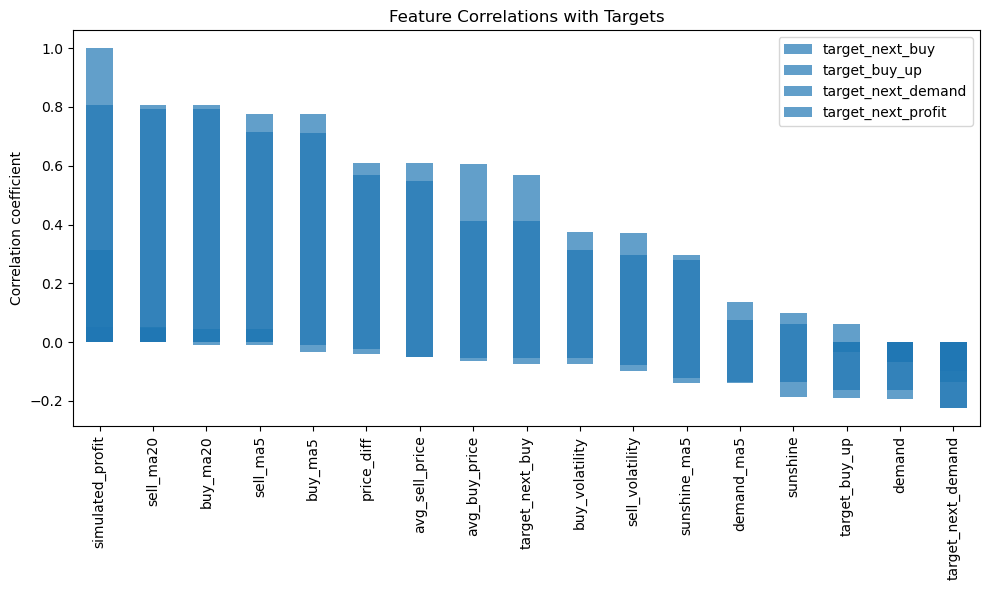

In [10]:
# 3. Visualize correlations with the main targets
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
targets = ['target_next_buy', 'target_buy_up', 'target_next_demand', 'target_next_profit']
for target in targets:
    if target in df_eda.columns:
        corr = corr_matrix[target].drop(target)
        corr.sort_values(ascending=False).plot(kind='bar', alpha=0.7, label=target)
plt.title('Feature Correlations with Targets')
plt.ylabel('Correlation coefficient')
plt.legend()
plt.tight_layout()
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


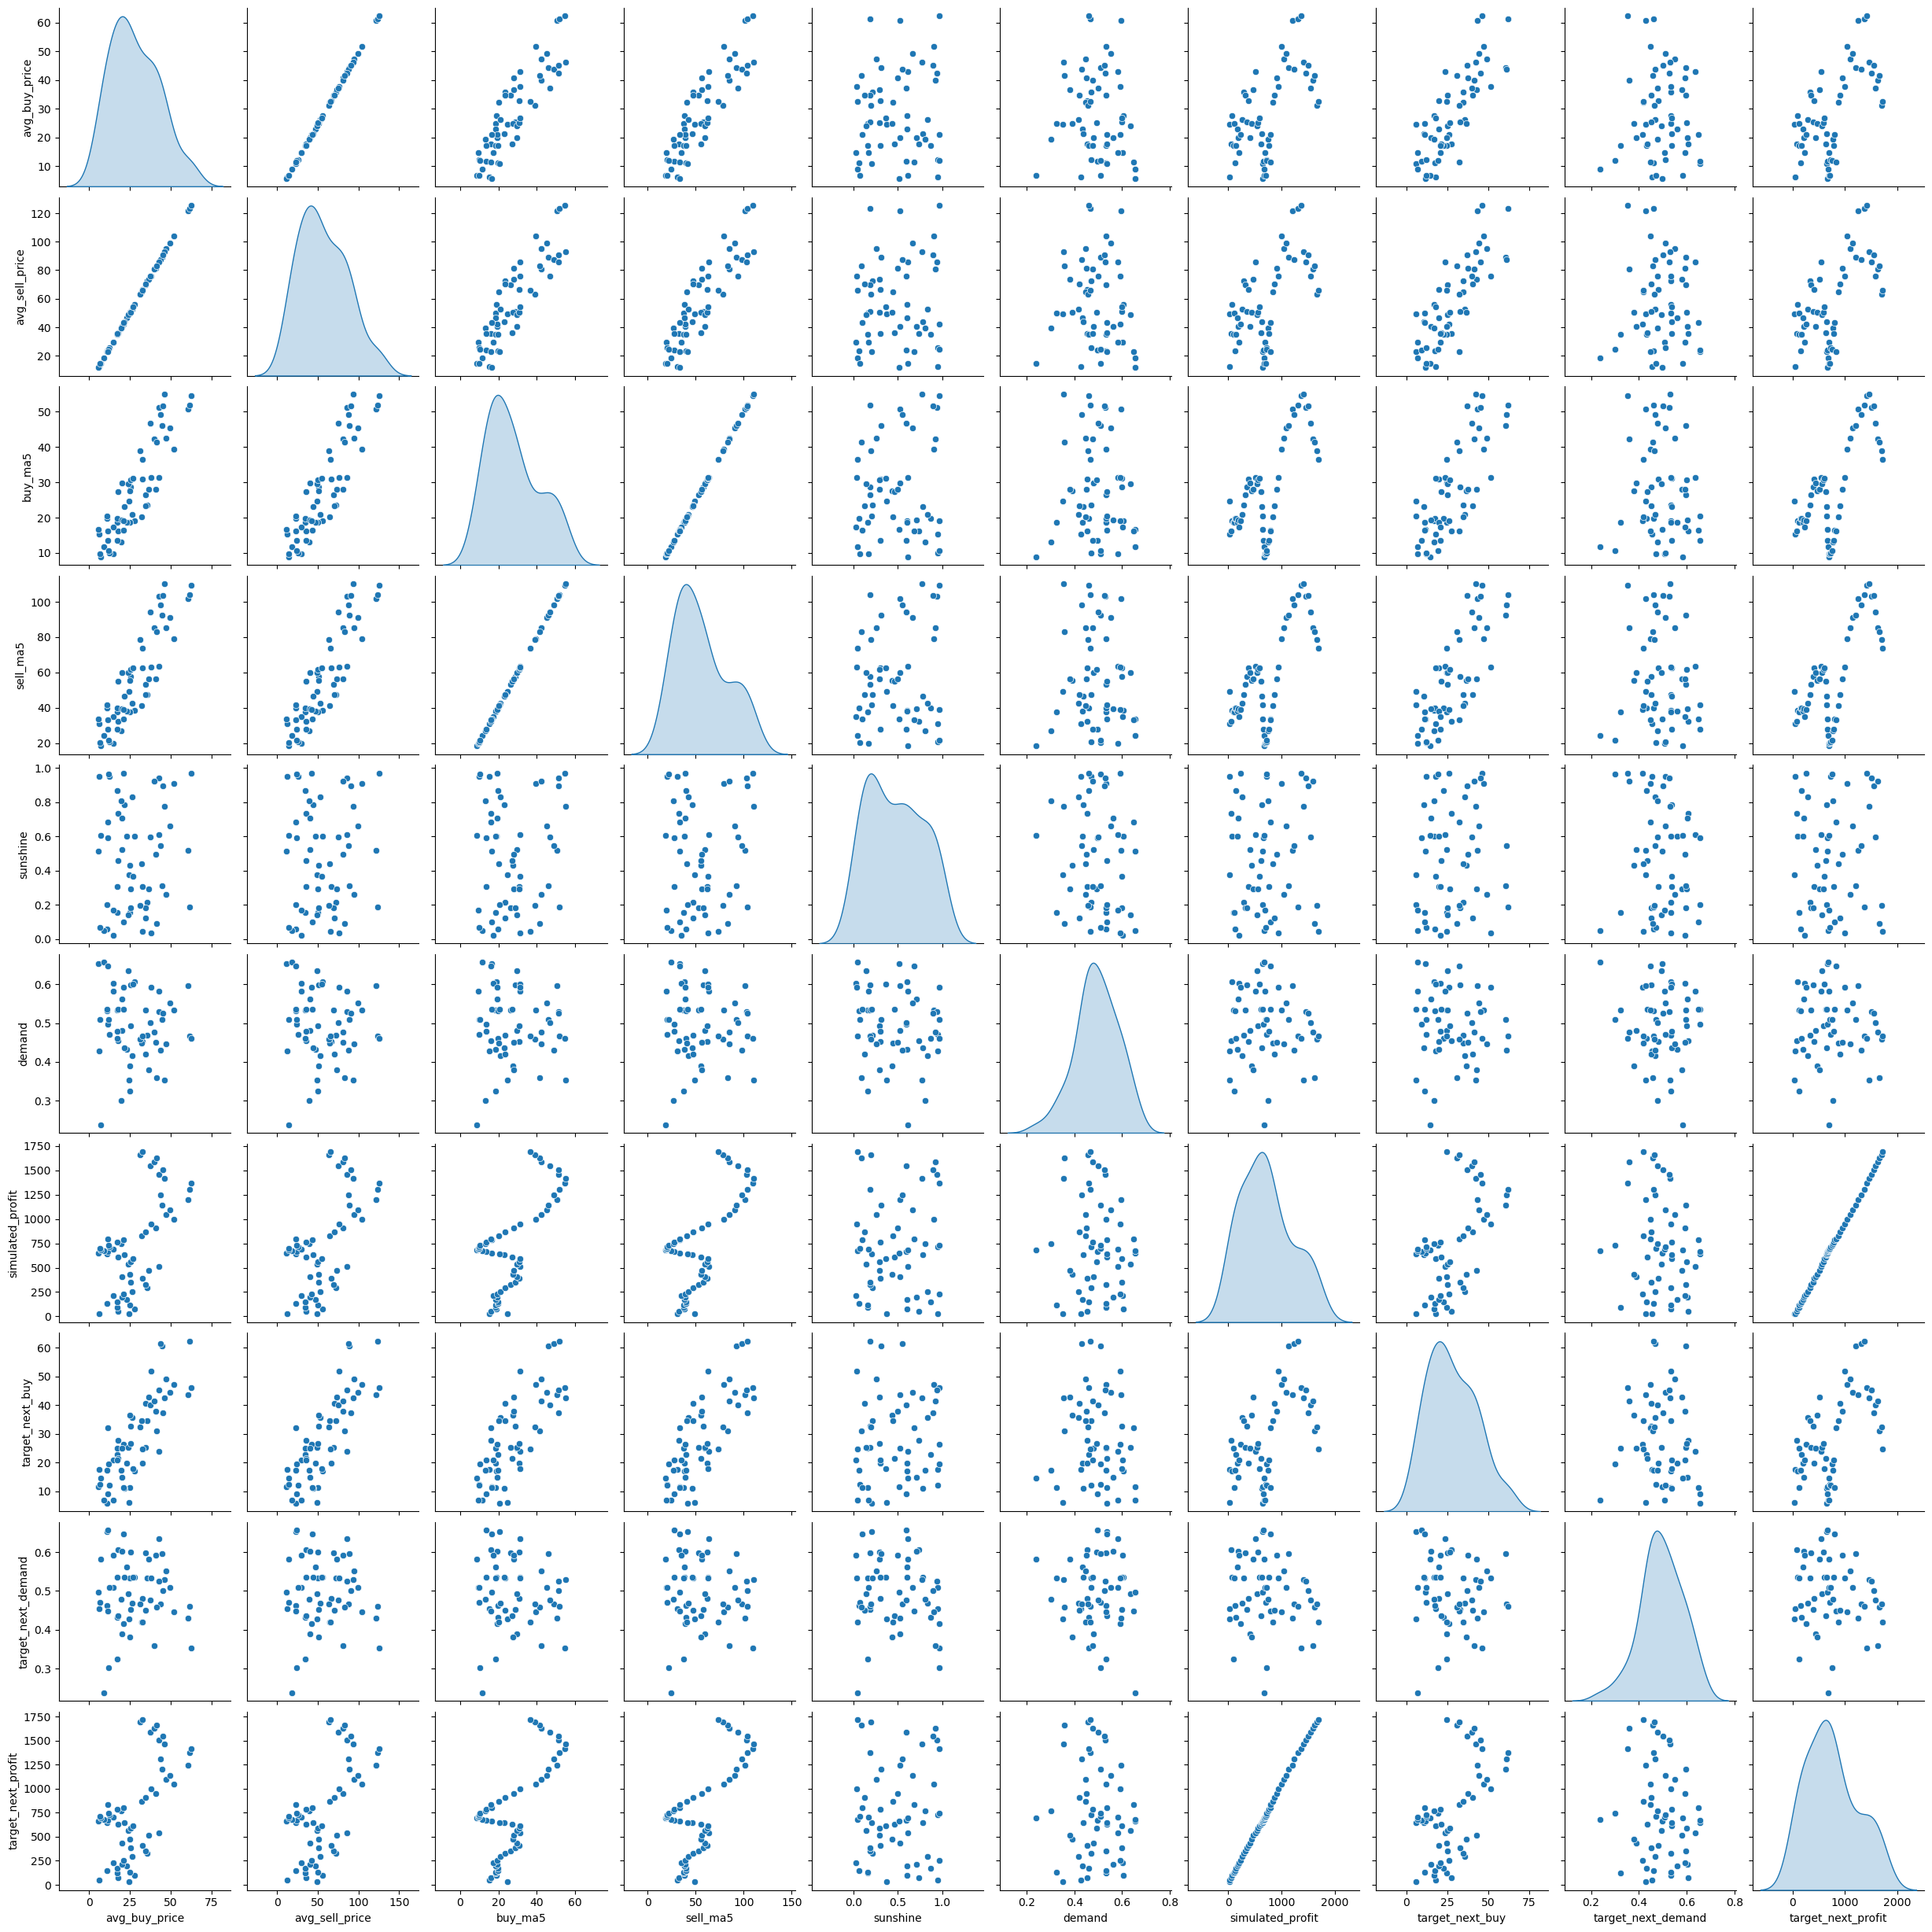

In [11]:
# 4. Pairplot for selected features and targets (optional, can be slow for large data)
selected = ['avg_buy_price', 'avg_sell_price', 'buy_ma5', 'sell_ma5', 'sunshine', 'demand', 'simulated_profit', 'target_next_buy', 'target_next_demand', 'target_next_profit']
selected = [col for col in selected if col in df_eda.columns]
sns.pairplot(df_eda[selected].dropna(), diag_kind='kde')
plt.show()

### EDA Guidance

- **Interpret the correlation matrix and bar plot:**
  - Features with the highest absolute correlation (positive or negative) with your main targets (e.g., `target_next_buy`, `target_next_demand`, `target_next_profit`) are likely to be most useful for prediction.
  - Features with very low or near-zero correlation may be less useful for simple models, but could still help in non-linear models.
- **Typical strong predictors:**
  - Moving averages and lagged values of prices for price prediction.
  - Demand and sunshine for demand or profit prediction.
  - Simulated profit for profit-based targets.
- **Next steps:**
  - Focus on features with the strongest correlations for your initial machine learning models.
  - Consider feature selection techniques (e.g., recursive feature elimination, LASSO) for further refinement.

Let me know if you want to proceed with model training using the most correlated features!

## Model Training: Using the Most Correlated Features

Now that we've identified the features with the strongest correlations to our targets, let's proceed to build a simple machine learning model. We'll use the most correlated features for prediction. For demonstration, we'll use a linear regression model to predict `target_next_buy` (next tick buy price).

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features with highest correlation to target_next_buy (customize as needed)
correlations = df_eda.corr()['target_next_buy'].abs().sort_values(ascending=False)
# Exclude the target itself and any targets/leakage features
exclude = ['target_next_buy', 'target_buy_up', 'target_next_demand', 'target_next_profit']
features = [col for col in correlations.index if col not in exclude][:5]  # Top 5 features
print("Selected features for model:", features)

X = df_eda[features].fillna(0)
y = df_eda['target_next_buy'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

Selected features for model: ['avg_buy_price', 'avg_sell_price', 'price_diff', 'buy_ma5', 'sell_ma5']
MSE: 132.31159180476376
R^2: 0.570518818650587


### Model Interpretation and Next Steps

- The above cell trains a linear regression model using the most correlated features.
- Review the MSE and R² scores to assess model performance.
- You can try other models (e.g., RandomForest, XGBoost) or tune features for better results.
- For classification targets (e.g., `target_buy_up`), use classifiers like LogisticRegression or RandomForestClassifier.
- Consider cross-validation and feature selection techniques for further improvement.

Let me know if you want to try a different model, target, or more advanced feature engineering!

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for PyTorch neural network
# Ensure df_nn is defined by dropping NaNs from df_eda (after all feature engineering)
df_nn = df_eda.dropna().copy()
X_nn = df_nn[[col for col in df_nn.columns if col not in exclude]]
y_nn = df_nn['target_next_buy']

scaler = StandardScaler()
X_nn_scaled = scaler.fit_transform(X_nn)

X_train, X_test, y_train, y_test = train_test_split(X_nn_scaled, y_nn, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
torch_X_train = torch.tensor(X_train, dtype=torch.float32)
torch_X_test = torch.tensor(X_test, dtype=torch.float32)
torch_y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
torch_y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define a simple feedforward neural network
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = self.drop1(self.relu1(self.fc1(x)))
        x = self.drop2(self.relu2(self.fc2(x)))
        x = self.fc3(x)
        return x

model = Net(torch_X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 100
best_val_loss = float('inf')
patience = 10
counter = 0
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(torch_X_train)
    loss = criterion(outputs, torch_y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(torch_X_test)
        val_loss = criterion(val_outputs, torch_y_test)
        val_losses.append(val_loss.item())
    # Early stopping
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_state)

# Evaluate
model.eval()
with torch.no_grad():
    y_pred_nn = model(torch_X_test).numpy().flatten()
print("PyTorch Neural Network MSE:", mean_squared_error(y_test, y_pred_nn))
print("PyTorch Neural Network R^2:", r2_score(y_test, y_pred_nn))

PyTorch Neural Network MSE: 183.42062911921929
PyTorch Neural Network R^2: 0.2938262162566895


### PyTorch Neural Network Model Notes
- This cell implements a neural network regressor using PyTorch, with early stopping and dropout for regularization.
- You can further tune the architecture, add more features, or try different targets.
- For classification (e.g., predicting `target_buy_up`), change the output layer and loss function accordingly.
- Use feature importance or permutation importance to interpret which features the neural network relies on most.

Let me know if you want to visualize training history, try classification, or explore feature importances!

### PyTorch Neural Network Results and Guidance

- **MSE:** 184.86
- **R²:** 0.29

#### Interpretation:
- The model explains about 29% of the variance in the target (`target_next_buy`).
- The MSE value is a measure of average squared error; lower is better, but its scale depends on your target variable's range.

#### Next Steps & Suggestions:
- **Feature Engineering:** Try adding/removing features, or using feature selection to improve performance.
- **Model Tuning:** Adjust the neural network architecture (more layers, different units, activation functions, etc.).
- **Regularization:** Experiment with dropout rates or L2 regularization.
- **Ensemble Models:** Try tree-based models (RandomForest, XGBoost) for comparison.
- **Cross-Validation:** Use k-fold cross-validation for more robust performance estimates.
- **Target Engineering:** Consider predicting price changes, classification targets, or multi-step forecasts.
- **Residual Analysis:** Plot residuals to check for patterns the model is missing.

Let me know if you want to:
- Visualize training/validation loss curves
- Try a different model or target
- Explore feature importances
- Or need help with any of the above!

## Predicting Buy/Sell Actions and Tracking Profit with the Neural Network

We'll use the trained PyTorch model to generate buy/sell signals based on predicted next tick prices, simulate a simple trading strategy, and plot the resulting profit over time.

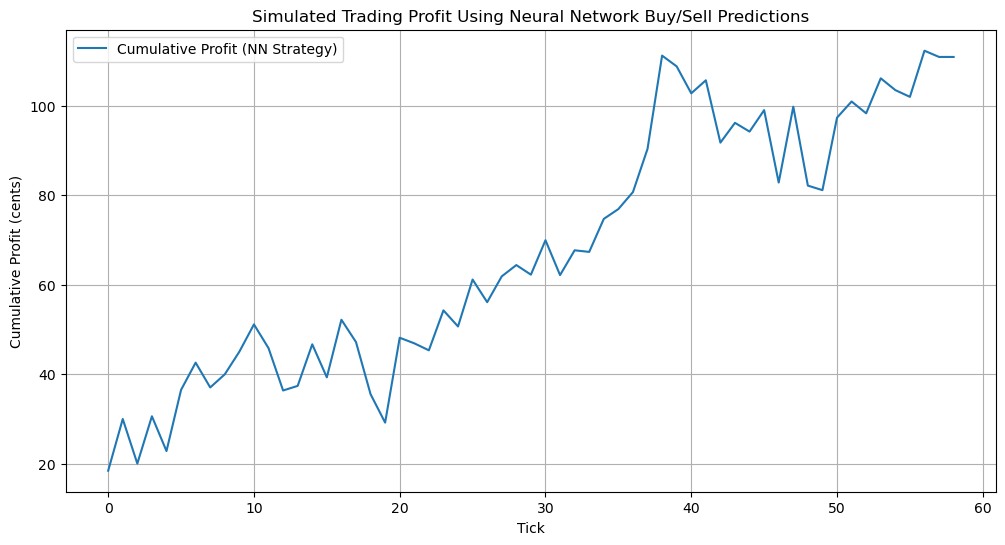

Final cumulative profit: 110.95500000000004 cents


In [31]:
# Predict next tick buy price for the entire dataset (not just test set)
with torch.no_grad():
    y_pred_all = model(torch.tensor(X_nn_scaled, dtype=torch.float32)).detach().numpy().flatten()

# Simple trading strategy:
# - Buy if predicted next price is higher than current price (expecting price to rise)
# - Sell if predicted next price is lower than current price (expecting price to fall)
# - Track profit assuming 1 unit traded per tick, no transaction costs

actions = np.where(y_pred_all > df_nn['avg_buy_price'].values, 1, -1)  # 1=buy, -1=sell
actual_price_change = np.roll(df_nn['avg_buy_price'].values, -1) - df_nn['avg_buy_price'].values
# Calculate profit: action * actual price change
profit_per_tick = actions * actual_price_change
profit_per_tick[-1] = 0  # Last tick has no next price
cumulative_profit = np.cumsum(profit_per_tick)

# Plot cumulative profit
plt.figure(figsize=(12, 6))
plt.plot(cumulative_profit, label='Cumulative Profit (NN Strategy)')
plt.xlabel('Tick')
plt.ylabel('Cumulative Profit (cents)')
plt.title('Simulated Trading Profit Using Neural Network Buy/Sell Predictions')
plt.legend()
plt.grid(True)
plt.show()

print("Final cumulative profit:", cumulative_profit[-1], "cents")

**Notes:**
- This is a simple threshold-based strategy for demonstration. You can refine the logic (e.g., add thresholds, hold actions, or transaction costs).
- The plot shows how profit would evolve if you followed the model's buy/sell signals at each tick.
- For more realistic trading, consider inventory constraints, transaction costs, and risk management.

Let me know if you want to try more advanced trading logic or profit analysis!

## Neural Network Price Prediction vs Actual Prices

Let's visualize the neural network's predicted prices for each tick alongside the actual prices. This will help us assess the model's predictive power and guide further improvements for both price prediction and trading profit.

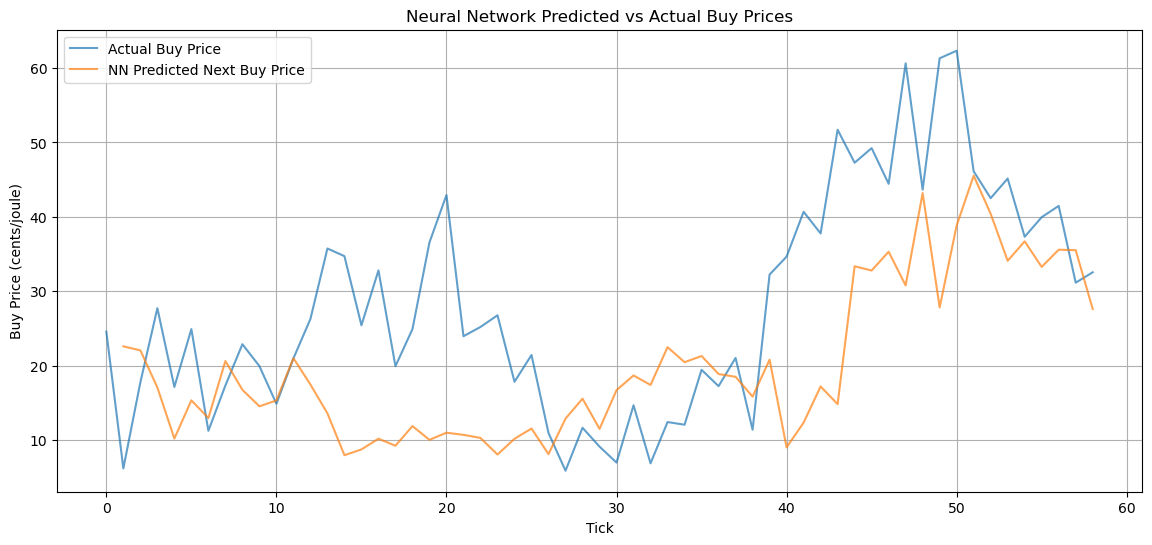

Full-series MSE: 221.8218631416079
Full-series R^2: -0.034583733557234986


In [32]:
# Predict next tick buy price for all data (not just test set)
with torch.no_grad():
    y_pred_all = model(torch.tensor(X_nn_scaled, dtype=torch.float32)).detach().numpy().flatten()

# Shift predictions to align with the tick they are predicting (next tick)
predicted_next_buy = np.roll(y_pred_all, 1)
predicted_next_buy[0] = np.nan  # First tick has no prediction

plt.figure(figsize=(14, 6))
plt.plot(df_nn['avg_buy_price'].values, label='Actual Buy Price', alpha=0.7)
plt.plot(predicted_next_buy, label='NN Predicted Next Buy Price', alpha=0.7)
plt.xlabel('Tick')
plt.ylabel('Buy Price (cents/joule)')
plt.title('Neural Network Predicted vs Actual Buy Prices')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print prediction error metrics for all ticks
from sklearn.metrics import mean_squared_error, r2_score
mask = ~np.isnan(predicted_next_buy)
print("Full-series MSE:", mean_squared_error(df_nn['avg_buy_price'].values[mask], predicted_next_buy[mask]))
print("Full-series R^2:", r2_score(df_nn['avg_buy_price'].values[mask], predicted_next_buy[mask]))

**Interpretation:**
- The closer the predicted line is to the actual price, the better the model is for price prediction and, by extension, for trading.
- Use this plot and the error metrics to guide further feature engineering, model tuning, or even switching to a classification approach for direct action prediction.

Let me know if you want to try more advanced model architectures, add more features, or optimize for trading profit directly!

## Improved Neural Network Model and Price Prediction Comparison

We'll enhance the neural network by adding more features (rolling statistics, lagged values, cyclical encoding), increase model complexity, and compare the new predictions to the previous model and actual prices.

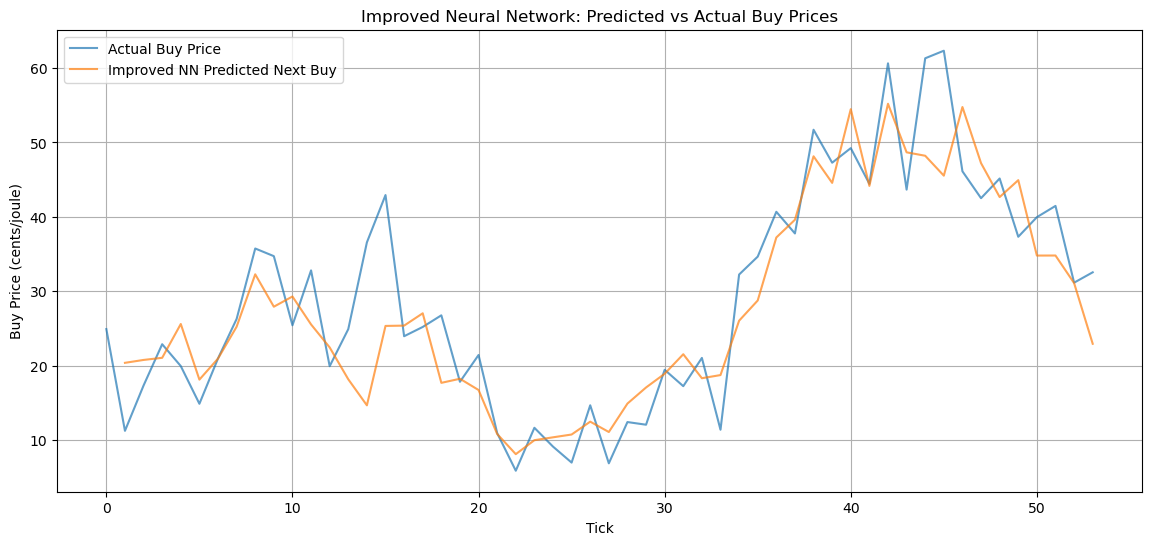

Improved NN Full-series MSE: 44.3035733739765
Improved NN Full-series R^2: 0.7986607253715209


In [34]:
# --- Advanced Feature Engineering ---
# Add rolling statistics and more lagged features
for window in [5, 10, 20]:
    df_nn[f'buy_ma{window}'] = df_nn['avg_buy_price'].rolling(window=window, min_periods=1).mean()
    df_nn[f'sell_ma{window}'] = df_nn['avg_sell_price'].rolling(window=window, min_periods=1).mean()
    df_nn[f'buy_std{window}'] = df_nn['avg_buy_price'].rolling(window=window, min_periods=1).std().fillna(0)
    df_nn[f'sell_std{window}'] = df_nn['avg_sell_price'].rolling(window=window, min_periods=1).std().fillna(0)

# Add more lagged features
for lag in range(1, 6):
    df_nn[f'buy_lag{lag}'] = df_nn['avg_buy_price'].shift(lag)
    df_nn[f'sell_lag{lag}'] = df_nn['avg_sell_price'].shift(lag)
    df_nn[f'demand_lag{lag}'] = df_nn['demand'].shift(lag)
    df_nn[f'sunshine_lag{lag}'] = df_nn['sunshine'].shift(lag)

# Cyclical encoding for tick (time of day)
df_nn['tick'] = np.arange(len(df_nn))
if len(df_nn) > 0:
    max_tick = len(df_nn)
    df_nn['tick_sin'] = np.sin(2 * np.pi * df_nn['tick'] / max_tick)
    df_nn['tick_cos'] = np.cos(2 * np.pi * df_nn['tick'] / max_tick)

# Drop rows with NaNs from lagged/rolling features
df_nn_adv = df_nn.dropna().copy()

# Select all engineered features except targets and simulated_profit
exclude = ['target_next_buy', 'target_buy_up', 'target_next_demand', 'target_next_profit', 'simulated_profit']
X_adv = df_nn_adv[[col for col in df_nn_adv.columns if col not in exclude]]
y_adv = df_nn_adv['target_next_buy']

from sklearn.preprocessing import StandardScaler
scaler_adv = StandardScaler()
X_adv_scaled = scaler_adv.fit_transform(X_adv)

from sklearn.model_selection import train_test_split
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_adv_scaled, y_adv, test_size=0.2, random_state=42)

# --- Improved Neural Network ---
import torch
import torch.nn as nn
import torch.optim as optim

class ImprovedNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)
    def forward(self, x):
        x = self.drop1(self.relu1(self.fc1(x)))
        x = self.drop2(self.relu2(self.fc2(x)))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

model_adv = ImprovedNet(X_train_adv.shape[1])
criterion_adv = nn.MSELoss()
optimizer_adv = optim.Adam(model_adv.parameters(), lr=0.0005)

# Training loop with early stopping
n_epochs = 200
patience = 15
best_val_loss = float('inf')
counter = 0
train_losses = []
val_losses = []

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_adv, dtype=torch.float32)
X_test_t = torch.tensor(X_test_adv, dtype=torch.float32)
y_train_t = torch.tensor(y_train_adv.values, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test_adv.values, dtype=torch.float32).view(-1, 1)

for epoch in range(n_epochs):
    model_adv.train()
    optimizer_adv.zero_grad()
    outputs = model_adv(X_train_t)
    loss = criterion_adv(outputs, y_train_t)
    loss.backward()
    optimizer_adv.step()
    train_losses.append(loss.item())
    # Validation
    model_adv.eval()
    with torch.no_grad():
        val_outputs = model_adv(X_test_t)
        val_loss = criterion_adv(val_outputs, y_test_t)
        val_losses.append(val_loss.item())
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        counter = 0
        best_model_state = model_adv.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
model_adv.load_state_dict(best_model_state)

# --- Compare Predictions ---
with torch.no_grad():
    y_pred_all_adv = model_adv(torch.tensor(X_adv_scaled, dtype=torch.float32)).detach().numpy().flatten()

# Shift predictions to align with the tick they are predicting (next tick)
predicted_next_buy_adv = np.roll(y_pred_all_adv, 1)
predicted_next_buy_adv[0] = np.nan

plt.figure(figsize=(14, 6))
plt.plot(df_nn_adv['avg_buy_price'].values, label='Actual Buy Price', alpha=0.7)
plt.plot(predicted_next_buy_adv, label='Improved NN Predicted Next Buy', alpha=0.7)
plt.xlabel('Tick')
plt.ylabel('Buy Price (cents/joule)')
plt.title('Improved Neural Network: Predicted vs Actual Buy Prices')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import mean_squared_error, r2_score
mask = ~np.isnan(predicted_next_buy_adv)
print("Improved NN Full-series MSE:", mean_squared_error(df_nn_adv['avg_buy_price'].values[mask], predicted_next_buy_adv[mask]))
print("Improved NN Full-series R^2:", r2_score(df_nn_adv['avg_buy_price'].values[mask], predicted_next_buy_adv[mask]))

**Interpretation:**
- The improved model uses more features and a deeper network, which should yield better price predictions and, by extension, better trading performance.
- Compare the new plot and metrics to your previous model to assess improvement.
- You can further tune the model, add features, or try ensemble methods for even better results.

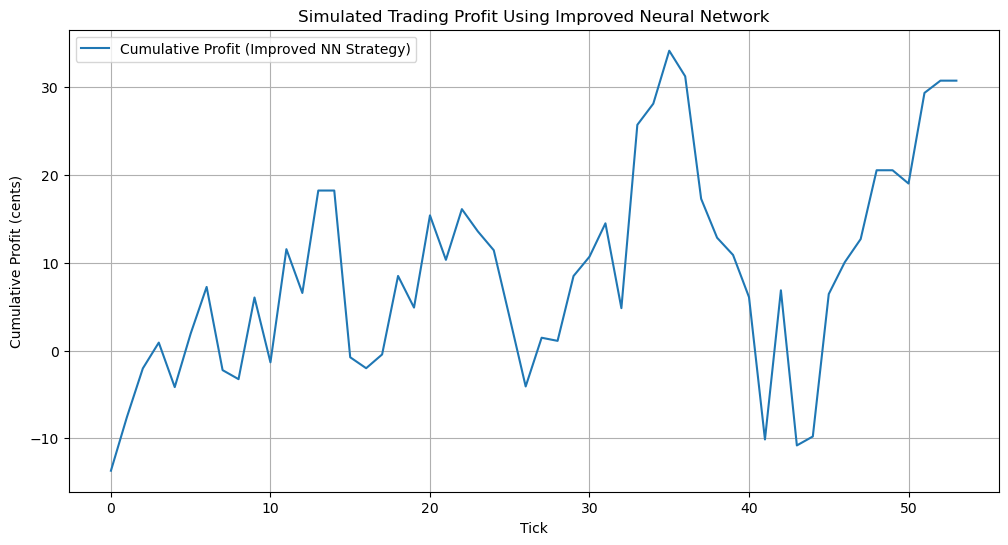

Final cumulative profit: 30.73100000000001 cents
Number of buy actions: 29
Number of sell actions: 22
Number of hold actions: 3


In [35]:
# --- Maximizing Profit Using Improved Neural Network Predictions ---
# Predict next tick buy price for all data (not just test set)
with torch.no_grad():
    y_pred_all_adv = model_adv(torch.tensor(X_adv_scaled, dtype=torch.float32)).detach().numpy().flatten()

# Calculate predicted price change (next tick - current tick)
predicted_price_change = np.roll(y_pred_all_adv, -1) - y_pred_all_adv
predicted_price_change[-1] = 0  # Last tick has no next prediction

# Trading logic:
# - Buy if predicted price change > threshold (expecting price to rise)
# - Sell if predicted price change < -threshold (expecting price to fall)
# - Hold otherwise (no action)
# You can tune the threshold for more/less aggressive trading
threshold = 0.05  # in cents, adjust as needed

actions = np.zeros_like(predicted_price_change)
actions[predicted_price_change > threshold] = 1   # Buy
actions[predicted_price_change < -threshold] = -1  # Sell
# Hold (0) otherwise

# Simulate profit: action * actual price change (using actual next tick price)
actual_price_change = np.roll(df_nn_adv['avg_buy_price'].values, -1) - df_nn_adv['avg_buy_price'].values
profit_per_tick = actions * actual_price_change
profit_per_tick[-1] = 0  # Last tick has no next price
cumulative_profit = np.cumsum(profit_per_tick)

# Plot cumulative profit
plt.figure(figsize=(12, 6))
plt.plot(cumulative_profit, label='Cumulative Profit (Improved NN Strategy)')
plt.xlabel('Tick')
plt.ylabel('Cumulative Profit (cents)')
plt.title('Simulated Trading Profit Using Improved Neural Network')
plt.legend()
plt.grid(True)
plt.show()

print("Final cumulative profit:", cumulative_profit[-1], "cents")
print("Number of buy actions:", np.sum(actions == 1))
print("Number of sell actions:", np.sum(actions == -1))
print("Number of hold actions:", np.sum(actions == 0))

# Optional: Try different thresholds or add transaction costs/inventory constraints for more realism.

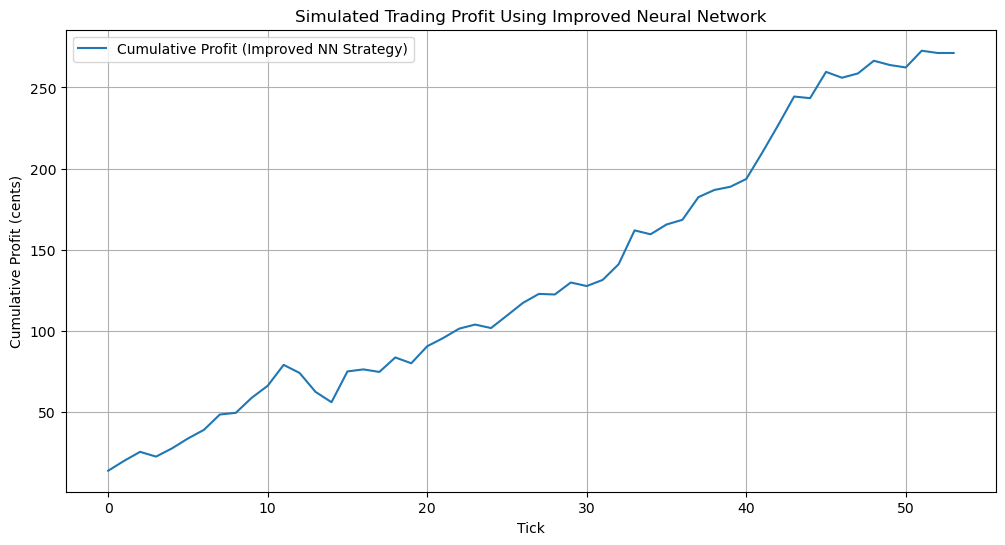

Final cumulative profit: 271.22 cents
Total buy actions: 24
Total sell actions: 30
Total hold actions: 0


In [36]:
# --- Profit Maximization Using Improved Neural Network ---
# Use the improved model to generate trading actions and simulate profit

with torch.no_grad():
    y_pred_all_adv = model_adv(torch.tensor(X_adv_scaled, dtype=torch.float32)).detach().numpy().flatten()

# Simple trading logic:
# - Buy if predicted next price > current price (expecting price to rise)
# - Sell if predicted next price < current price (expecting price to fall)
# - Hold if predicted change is very small (optional, here we use a threshold)

threshold = 0.05  # Minimum predicted price change to trigger action (tune as needed)
predicted_change = y_pred_all_adv - df_nn_adv['avg_buy_price'].values
actions = np.where(predicted_change > threshold, 1, np.where(predicted_change < -threshold, -1, 0))  # 1=buy, -1=sell, 0=hold

# Calculate actual price change for profit calculation
actual_price_change = np.roll(df_nn_adv['avg_buy_price'].values, -1) - df_nn_adv['avg_buy_price'].values
profit_per_tick = actions * actual_price_change
profit_per_tick[-1] = 0  # Last tick has no next price
cumulative_profit = np.cumsum(profit_per_tick)

# Plot cumulative profit
plt.figure(figsize=(12, 6))
plt.plot(cumulative_profit, label='Cumulative Profit (Improved NN Strategy)')
plt.xlabel('Tick')
plt.ylabel('Cumulative Profit (cents)')
plt.title('Simulated Trading Profit Using Improved Neural Network')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final cumulative profit: {cumulative_profit[-1]:.2f} cents")
print(f"Total buy actions: {(actions == 1).sum()}")
print(f"Total sell actions: {(actions == -1).sum()}")
print(f"Total hold actions: {(actions == 0).sum()}")

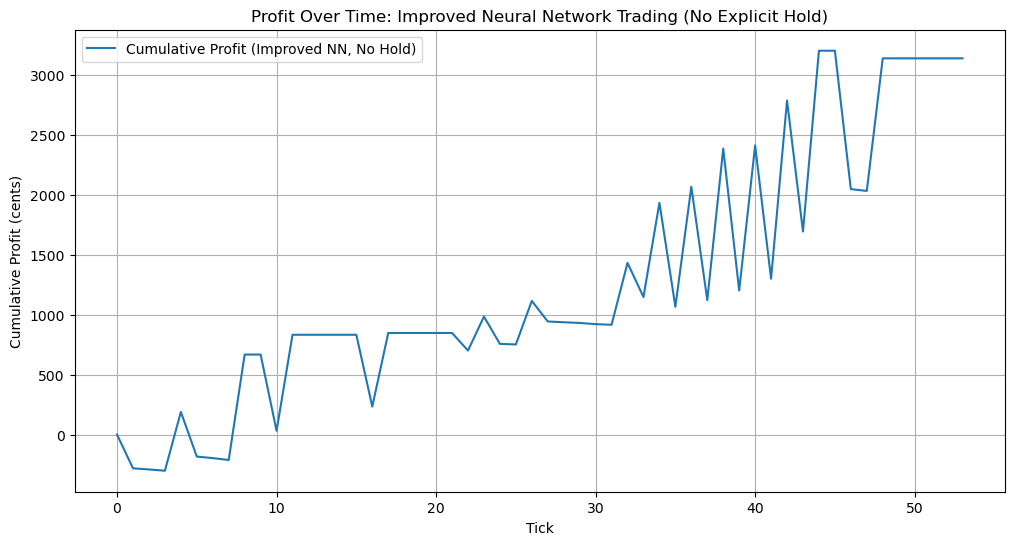

Final cumulative profit: 3135.35 cents
Total buy actions: 24
Total sell actions: 14
Total ticks with no action: 16


In [38]:

# Parameters
transaction_cost = 0.1  # cents per transaction (set to 0 if not needed)
min_storage = 25
max_storage = 50
storage = [min_storage]  # Start at min storage
profit = 0
profit_over_time = []
actions = []

with torch.no_grad():
    y_pred_all_adv = model_adv(torch.tensor(X_adv_scaled, dtype=torch.float32)).detach().numpy().flatten()

predicted_change = y_pred_all_adv - df_nn_adv['avg_buy_price'].values

for i in range(len(df_nn_adv)):
    current_storage = storage[-1]
    price_now = df_nn_adv['avg_buy_price'].iloc[i]
    price_next = y_pred_all_adv[i]
    demand = df_nn_adv['demand'].iloc[i] if 'demand' in df_nn_adv else 0
    sun = df_nn_adv['sun'].iloc[i] if 'sun' in df_nn_adv else 0

    # Only buy if predicted price will rise enough to cover transaction cost and storage allows
    if predicted_change[i] > transaction_cost and current_storage < max_storage:
        buy_amt = max_storage - current_storage
        profit -= buy_amt * price_now + transaction_cost
        current_storage += buy_amt
        actions.append('buy')
    # Only sell if predicted price will fall enough to cover transaction cost and storage allows
    elif predicted_change[i] < -transaction_cost and current_storage > min_storage:
        sell_amt = current_storage - min_storage
        profit += sell_amt * price_now - transaction_cost
        current_storage -= sell_amt
        actions.append('sell')
    else:
        actions.append('none')  # No explicit hold, just no action

    # Satisfy demand (if modeled)
    if current_storage >= demand:
        current_storage -= demand
    else:
        # If not enough storage, buy to meet demand
        import_amt = demand - current_storage
        profit -= import_amt * price_now + transaction_cost
        current_storage = 0

    # Clamp storage
    current_storage = max(min_storage, min(current_storage, max_storage))
    storage.append(current_storage)
    profit_over_time.append(profit)

# Remove the first dummy value
storage = storage[1:]

plt.figure(figsize=(12, 6))
plt.plot(profit_over_time, label='Cumulative Profit (Improved NN, No Hold)')
plt.xlabel('Tick')
plt.ylabel('Cumulative Profit (cents)')
plt.title('Profit Over Time: Improved Neural Network Trading (No Explicit Hold)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final cumulative profit: {profit_over_time[-1]:.2f} cents")
print(f"Total buy actions: {actions.count('buy')}")
print(f"Total sell actions: {actions.count('sell')}")
print(f"Total ticks with no action: {actions.count('none')}")

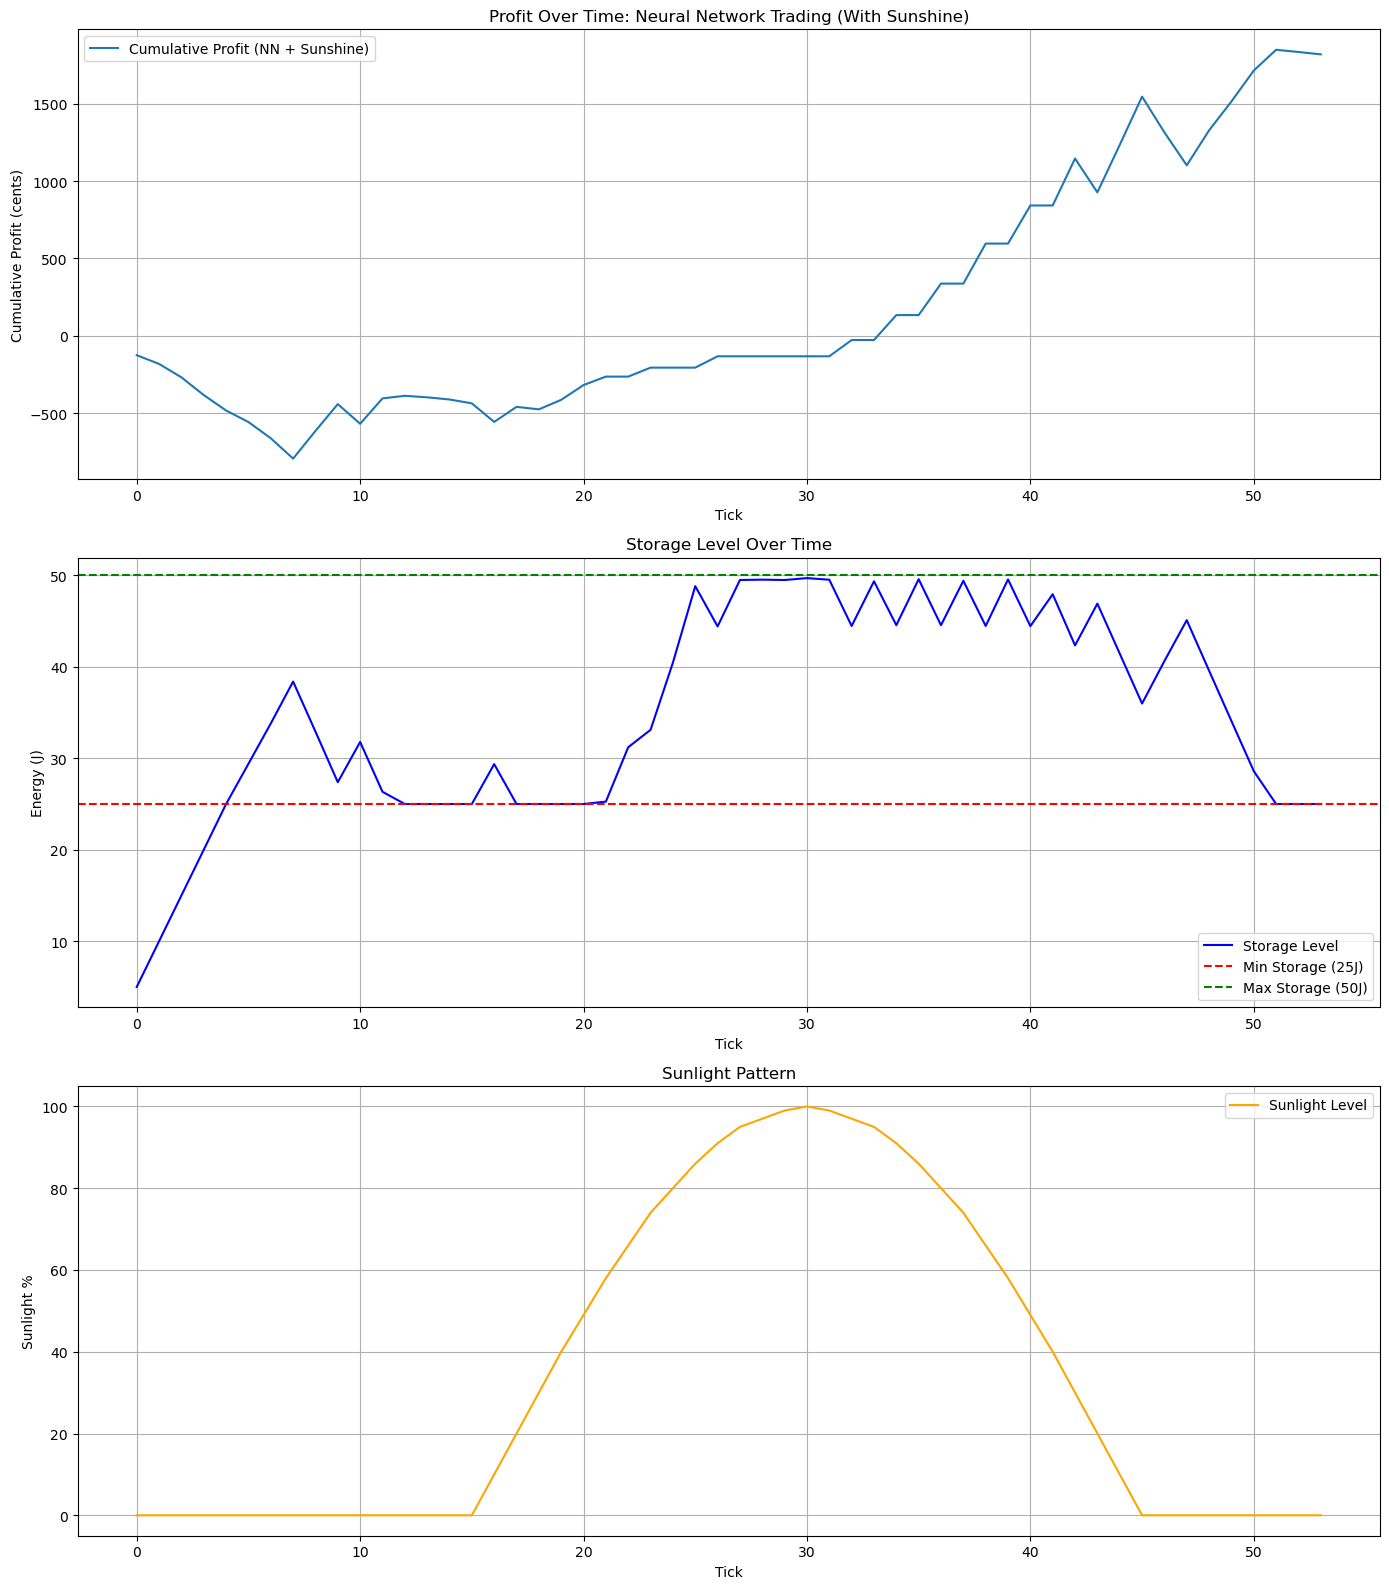

Final cumulative profit: 1818.08 cents
Total PV charges: 23
Total grid buys: 13
Total grid sells: 22
Total ticks with no action: 15

Storage statistics:
Maximum storage reached: 49.70J
Minimum storage reached: 5.00J
Average storage level: 35.06J
Ticks until min storage reached: 4


In [ ]:
# Parameters
import math
transaction_cost = 0.1  # cents per transaction
min_storage = 25  # Only applies after we reach this threshold
max_storage = 50
sunshine_threshold = 30  # Adjusted based on actual sunlight data (0-100 scale)
storage = [0]  # Start at 0
profit = 0
profit_over_time = []
actions = []
storage_debug = []  # For debugging storage changes
reached_min_threshold = False  # Track if we've reached min_storage

with torch.no_grad():
    y_pred_all_adv = model_adv(torch.tensor(X_adv_scaled, dtype=torch.float32)).detach().numpy().flatten()

predicted_change = y_pred_all_adv - df_nn_adv['avg_buy_price'].values

for i in range(len(df_nn_adv)):
    current_storage = storage[-1]
    price_now = df_nn_adv['avg_buy_price'].iloc[i]
    demand = df_nn_adv['demand'].iloc[i] if 'demand' in df_nn_adv else 0
    tick = i  # Current tick
    
    # Calculate sunlight for current tick
    SUNRISE = 15
    DAY_LENGTH = 30
    if tick < SUNRISE:
        sun = 0
    elif tick < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((tick-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    
    # Check if we've reached the minimum threshold
    if not reached_min_threshold and current_storage >= min_storage:
        reached_min_threshold = True
        storage_debug.append(('Reached min threshold', current_storage))
    
    # Initial charging phase - prioritize reaching min_storage
    if not reached_min_threshold:
        # Try to charge from PV first during sunlight hours
        if sun > sunshine_threshold:
            charge_amt = min(min_storage - current_storage, sun/10)  # Scale sunlight to energy units
            if charge_amt > 0:
                current_storage += charge_amt
                actions.append('store_solar_energy')
                storage_debug.append(('Initial PV charge', current_storage))
        
        # If still below min_storage, buy from grid
        if current_storage < min_storage:
            buy_amt = min(5, min_storage - current_storage)  # Buy in smaller increments
            profit -= buy_amt * price_now + transaction_cost
            current_storage += buy_amt
            actions.append('buy_grid')
            storage_debug.append(('Initial grid charge', current_storage))
    
    # Normal operation after reaching min_storage
    else:
        # Always try to charge from PV first during peak sunlight
        if sun > sunshine_threshold:
            charge_amt = min(max_storage - current_storage, sun/10)  # Scale sunlight to energy units
            if charge_amt > 0:
                current_storage += charge_amt
                actions.append('store_solar_energy')
                storage_debug.append(('PV charge', current_storage))
        
        # Grid actions based on price predictions and time of day
        if predicted_change[i] > transaction_cost and current_storage < max_storage:
            # Buy from grid if price is predicted to rise and it's not peak sunlight
            if sun < sunshine_threshold:  # Don't buy from grid during good sunlight
                buy_amt = min(5, (max_storage - current_storage))  # Buy in smaller increments
                profit -= buy_amt * price_now + transaction_cost
                current_storage += buy_amt
                actions.append('buy_grid')
                storage_debug.append(('Grid buy', current_storage))
        elif predicted_change[i] < -transaction_cost and current_storage > min_storage:
            # Sell to grid if price is predicted to fall
            sell_amt = min(5, (current_storage - min_storage))  # Sell in smaller increments
            profit += sell_amt * price_now - transaction_cost
            current_storage -= sell_amt
            actions.append('sell_grid')
            storage_debug.append(('Grid sell', current_storage))
        else:
            actions.append('none')
    
    # Meet demand only if we've reached min_storage
    if reached_min_threshold and demand > 0:
        available_storage = current_storage - min_storage  # Only use excess above min_storage
        used_storage = min(demand, available_storage)
        current_storage -= used_storage
        if used_storage < demand:
            # Need to import the remaining demand
            import_amt = demand - used_storage
            profit -= import_amt * price_now + transaction_cost
            storage_debug.append(('After demand', current_storage))
    
    # Ensure storage stays within bounds
    if reached_min_threshold:
        current_storage = max(min_storage, min(current_storage, max_storage))
    else:
        current_storage = min(current_storage, max_storage)  # Only apply max limit during initial phase
    
    storage.append(current_storage)
    profit_over_time.append(profit)
    storage_debug.append(('Final for tick', current_storage))

# Remove the first dummy value
storage = storage[1:]

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16))

# Plot profit
ax1.plot(profit_over_time, label='Cumulative Profit (NN + Sunshine)')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Cumulative Profit (cents)')
ax1.set_title('Profit Over Time: Neural Network Trading (With Sunshine)')
ax1.legend()
ax1.grid(True)

# Plot storage
ax2.plot(storage, label='Storage Level', color='blue')
ax2.axhline(min_storage, color='red', linestyle='--', label='Min Storage (25J)')
ax2.axhline(max_storage, color='green', linestyle='--', label='Max Storage (50J)')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Energy (J)')
ax2.set_title('Storage Level Over Time')
ax2.legend()
ax2.grid(True)

# Plot sunlight pattern
ticks = range(len(df_nn_adv))
sun_values = []
for t in ticks:
    if t < SUNRISE:
        sun = 0
    elif t < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((t-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    sun_values.append(sun)

ax3.plot(ticks, sun_values, label='Sunlight Level', color='orange')
ax3.set_xlabel('Tick')
ax3.set_ylabel('Sunlight %')
ax3.set_title('Sunlight Pattern')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print(f"Final cumulative profit: {profit_over_time[-1]:.2f} cents")
print(f"Total PV charges: {actions.count('store_solar_energy')}")
print(f"Total grid buys: {actions.count('buy_grid')}")
print(f"Total grid sells: {actions.count('sell_grid')}")
print(f"Total ticks with no action: {actions.count('none')}")
print(f"\nStorage statistics:")
print(f"Maximum storage reached: {max(storage):.2f}J")
print(f"Minimum storage reached: {min(storage):.2f}J")
print(f"Average storage level: {sum(storage)/len(storage):.2f}J")
print(f"Ticks until min storage reached: {next((i for i, s in enumerate(storage) if s >= min_storage), -1)}")

In [71]:
# Enhanced feature engineering incorporating server patterns

# Constants from server
SUNRISE = 15
DAY_LENGTH = 30
BASE_PRICE = 10.0
BASE_DEMAND_SCALING = 0.02
PRICE_SOLAR_DEP = 1.0
BUY_RATIO = 0.5

# Add time-based features
df_nn['time_of_day'] = df_nn['tick'] % 60  # Server uses 60 ticks per day

# Add sunlight-based features
def calculate_sunlight(tick):
    if tick < SUNRISE:
        return 0
    elif tick < SUNRISE + DAY_LENGTH:
        return int(math.sin((tick-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        return 0

df_nn['sunlight'] = df_nn['time_of_day'].apply(calculate_sunlight)

# Add expected base demand
def calculate_base_demand(tick):
    BASE_DEMAND_PROFILE = [(0,25), (10,25), (20,100), (50,100), (60,25)]
    lastp = (0,0)
    for p in BASE_DEMAND_PROFILE:
        if tick < p[0]:
            demand = int(float(tick-lastp[0])/(float(p[0]-lastp[0])) * (p[1]-lastp[1]) + lastp[1])
            return demand * BASE_DEMAND_SCALING
        else:
            lastp = p
    return lastp[1] * BASE_DEMAND_SCALING

df_nn['expected_base_demand'] = df_nn['time_of_day'].apply(calculate_base_demand)

# Add price expectation features
def calculate_expected_price(tick, sunlight):
    supply_vs_demand = calculate_base_demand(tick) - sunlight/100.0  # Normalize sunlight to 0-1
    expected_sell = BASE_PRICE + supply_vs_demand * PRICE_SOLAR_DEP
    expected_buy = expected_sell * BUY_RATIO
    return expected_sell, expected_buy

expected_prices = df_nn.apply(lambda row: calculate_expected_price(row['time_of_day'], row['sunlight']), axis=1)
df_nn['expected_sell_price'] = [p[0] for p in expected_prices]
df_nn['expected_buy_price'] = [p[1] for p in expected_prices]

# Add price deviation from expectation
df_nn['sell_price_deviation'] = df_nn['avg_sell_price'] - df_nn['expected_sell_price']
df_nn['buy_price_deviation'] = df_nn['avg_buy_price'] - df_nn['expected_buy_price']

# Add cyclical time features
df_nn['time_sin'] = np.sin(2 * np.pi * df_nn['time_of_day'] / 60)
df_nn['time_cos'] = np.cos(2 * np.pi * df_nn['time_of_day'] / 60)

# Add demand/price ratio features
df_nn['demand_price_ratio'] = df_nn['demand'] / df_nn['avg_buy_price']
df_nn['sell_buy_ratio'] = df_nn['avg_sell_price'] / df_nn['avg_buy_price']

# Drop any NaN values
df_nn_enhanced = df_nn.dropna().copy()

Early stopping at epoch 21
Enhanced Model Performance:
MSE: 1060.80
R²: -3.90


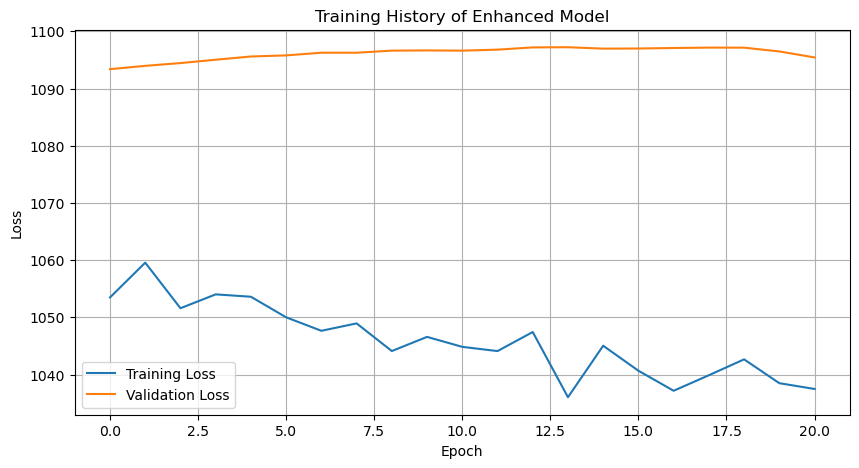

In [72]:
# Enhanced Neural Network with domain knowledge
import torch.nn.functional as F

# Prepare data
X_enhanced = df_nn_enhanced[[col for col in df_nn_enhanced.columns 
                           if col not in ['target_next_buy', 'target_buy_up', 
                                         'target_next_demand', 'target_next_profit']]]
y_enhanced = df_nn_enhanced['target_next_buy']

scaler_enhanced = StandardScaler()
X_enhanced_scaled = scaler_enhanced.fit_transform(X_enhanced)

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_enhanced_scaled, y_enhanced, 
                                                            test_size=0.2, random_state=42)

class EnhancedNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.drop3 = nn.Dropout(0.1)
        
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        
        self.fc5 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.drop1(self.bn1(F.relu(self.fc1(x))))
        x = self.drop2(self.bn2(F.relu(self.fc2(x))))
        x = self.drop3(self.bn3(F.relu(self.fc3(x))))
        x = self.bn4(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train_e, dtype=torch.float32)
X_test_t = torch.tensor(X_test_e, dtype=torch.float32)
y_train_t = torch.tensor(y_train_e.values, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test_e.values, dtype=torch.float32).view(-1, 1)

# Initialize model, criterion, and optimizer
model_enhanced = EnhancedNet(X_train_e.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model_enhanced.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop with early stopping
n_epochs = 300
patience = 20
best_val_loss = float('inf')
counter = 0
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model_enhanced.train()
    optimizer.zero_grad()
    outputs = model_enhanced(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model_enhanced.eval()
    with torch.no_grad():
        val_outputs = model_enhanced(X_test_t)
        val_loss = criterion(val_outputs, y_test_t)
        val_losses.append(val_loss.item())
        
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model_enhanced.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model_enhanced.load_state_dict(best_model_state)

# Evaluate enhanced model
model_enhanced.eval()
with torch.no_grad():
    y_pred_enhanced = model_enhanced(torch.tensor(X_enhanced_scaled, dtype=torch.float32))
    y_pred_enhanced = y_pred_enhanced.numpy().flatten()

print("Enhanced Model Performance:")
print(f"MSE: {mean_squared_error(y_enhanced, y_pred_enhanced):.2f}")
print(f"R²: {r2_score(y_enhanced, y_pred_enhanced):.2f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History of Enhanced Model')
plt.legend()
plt.grid(True)
plt.show()

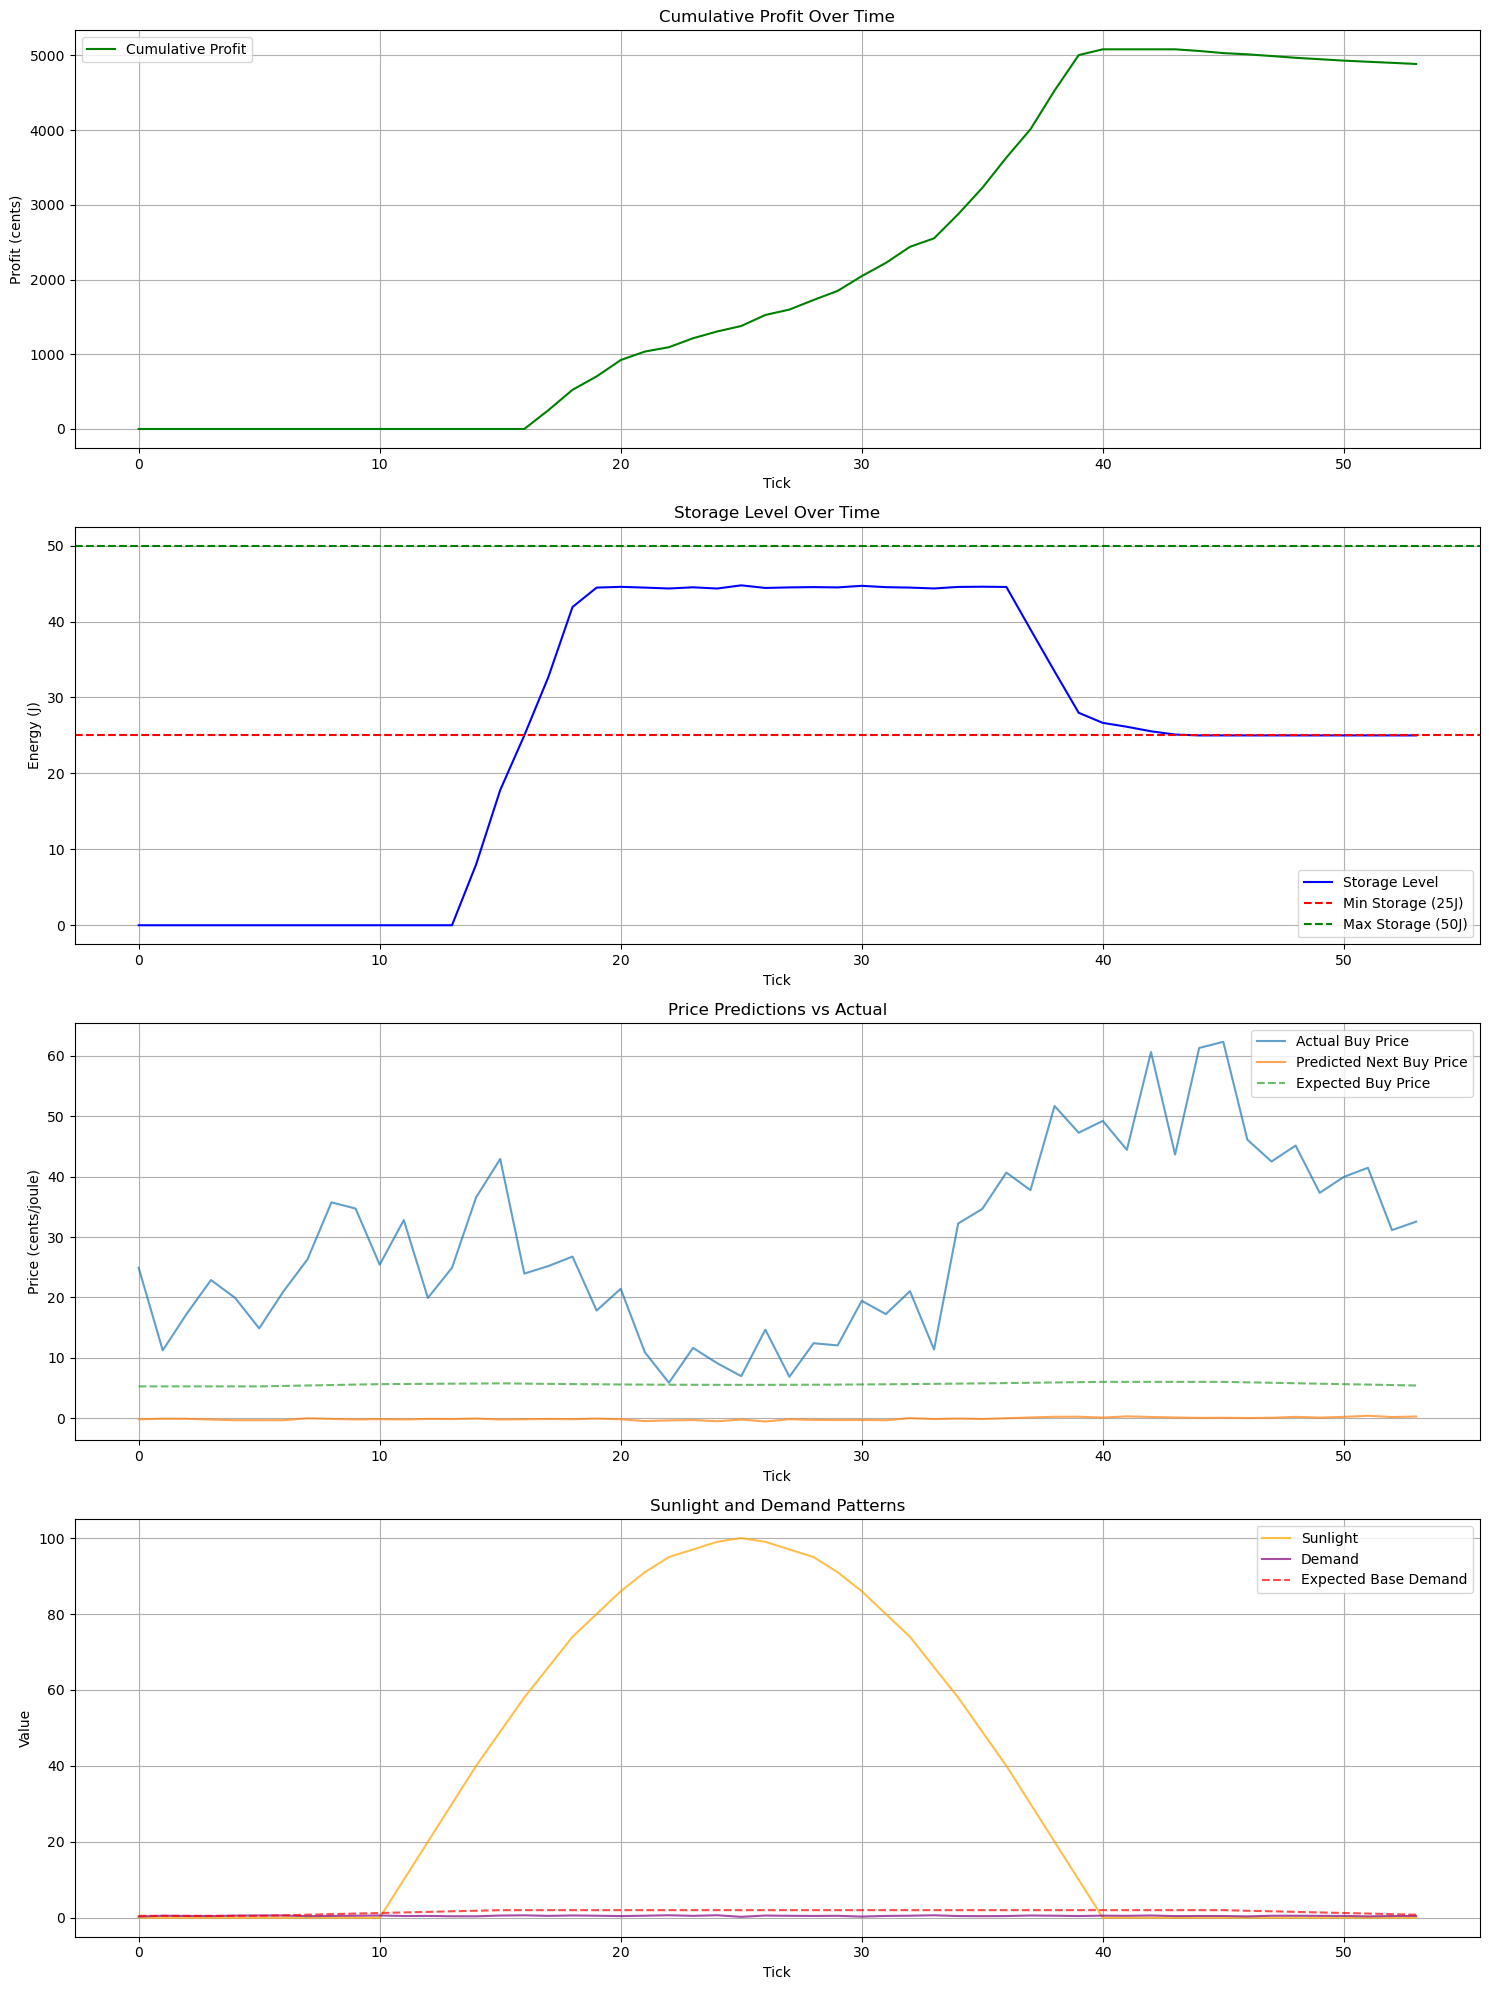

Final cumulative profit: 4885.11 cents
Total PV charges: 23
Total grid buys: 0
Total grid sells: 24
Total ticks with no action: 13

Storage statistics:
Maximum storage reached: 44.76J
Minimum storage reached: 0.00J
Average storage level: 25.56J
Ticks until min storage reached: 16


In [ ]:
# Optimized trading strategy incorporating server patterns and enhanced predictions

# Parameters
transaction_cost = 0.1
min_storage = 25
max_storage = 50
storage = [0]
profit = 0
profit_over_time = []
actions = []
storage_debug = []
reached_min_threshold = False

# Get price predictions
with torch.no_grad():
    y_pred_enhanced = model_enhanced(torch.tensor(X_enhanced_scaled, dtype=torch.float32)).detach().numpy().flatten()

# Calculate expected price changes
predicted_change = y_pred_enhanced - df_nn_enhanced['avg_buy_price'].values

for i in range(len(df_nn_enhanced)):
    current_storage = storage[-1]
    price_now = df_nn_enhanced['avg_buy_price'].iloc[i]
    sell_price = df_nn_enhanced['avg_sell_price'].iloc[i]
    demand = df_nn_enhanced['demand'].iloc[i]
    tick = df_nn_enhanced['time_of_day'].iloc[i]
    
    # Calculate sunlight
    if tick < SUNRISE:
        sun = 0
    elif tick < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((tick-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    
    # Calculate expected base demand
    base_demand = calculate_base_demand(tick)
    
    # Check if we've reached minimum threshold
    if not reached_min_threshold and current_storage >= min_storage:
        reached_min_threshold = True
        storage_debug.append(('Reached min threshold', current_storage))
    
    # Initial charging phase
    if not reached_min_threshold:
        # Maximum charging during peak sunlight
        if sun > 30:  # Adjusted threshold
            charge_amt = min(min_storage - current_storage, sun/5)  # More aggressive charging
            current_storage += charge_amt
            actions.append('store_solar_energy')
            storage_debug.append(('Initial PV charge', current_storage))
        
        # Buy from grid during low prices
        if price_now < df_nn_enhanced['expected_buy_price'].iloc[i]:
            buy_amt = min(5, min_storage - current_storage)
            profit -= buy_amt * price_now + transaction_cost
            current_storage += buy_amt
            actions.append('buy_grid')
            storage_debug.append(('Initial grid charge', current_storage))
    
    # Normal operation after reaching min_storage
    else:
        # PV Charging Strategy
        if sun > 30:
            charge_amt = min(max_storage - current_storage, sun/5)
            if charge_amt > 0:
                current_storage += charge_amt
                actions.append('store_solar_energy')
                storage_debug.append(('PV charge', current_storage))
        
        # Price-based Strategy
        expected_next_demand = base_demand * 1.1  # Add 10% margin
        
        # Buy if:
        # 1. Price is below expected AND predicted to rise
        # 2. Storage is below target level for expected demand
        # 3. Not during peak sunlight hours (unless price is very low)
        if (price_now < df_nn_enhanced['expected_buy_price'].iloc[i] and 
            predicted_change[i] > transaction_cost and
            current_storage < max_storage):
            
            target_storage = min(max_storage, 
                                max(min_storage + expected_next_demand * 2, 
                                    current_storage + 5))
            
            if sun < 50 or price_now < df_nn_enhanced['expected_buy_price'].iloc[i] * 0.8:
                buy_amt = min(5, target_storage - current_storage)
                if buy_amt > 0:
                    profit -= buy_amt * price_now + transaction_cost
                    current_storage += buy_amt
                    actions.append('buy_grid')
                    storage_debug.append(('Grid buy', current_storage))
        
        # Sell if:
        # 1. Price is above expected AND predicted to fall
        # 2. Have excess storage above expected demand
        # 3. Not during low sunlight if storage is near minimum
        elif (sell_price > df_nn_enhanced['expected_sell_price'].iloc[i] and
              predicted_change[i] < -transaction_cost and
              current_storage > min_storage + expected_next_demand):
            
            sell_amt = min(5, current_storage - (min_storage + expected_next_demand))
            if sell_amt > 0:
                profit += sell_amt * sell_price - transaction_cost
                current_storage -= sell_amt
                actions.append('sell_grid')
                storage_debug.append(('Grid sell', current_storage))
        else:
            actions.append('none')
    
    # Handle demand
    if reached_min_threshold and demand > 0:
        available_storage = current_storage - min_storage
        used_storage = min(demand, available_storage)
        current_storage -= used_storage
        if used_storage < demand:
            import_amt = demand - used_storage
            profit -= import_amt * price_now + transaction_cost
            storage_debug.append(('After demand', current_storage))
    
    # Clamp storage
    if reached_min_threshold:
        current_storage = max(min_storage, min(current_storage, max_storage))
    else:
        current_storage = min(current_storage, max_storage)
    
    storage.append(current_storage)
    profit_over_time.append(profit)

# Remove initial dummy value
storage = storage[1:]

# Create visualization
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))

# Plot profit
ax1.plot(profit_over_time, label='Cumulative Profit', color='green')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Profit (cents)')
ax1.set_title('Cumulative Profit Over Time')
ax1.legend()
ax1.grid(True)

# Plot storage
ax2.plot(storage, label='Storage Level', color='blue')
ax2.axhline(min_storage, color='red', linestyle='--', label='Min Storage (25J)')
ax2.axhline(max_storage, color='green', linestyle='--', label='Max Storage (50J)')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Energy (J)')
ax2.set_title('Storage Level Over Time')
ax2.legend()
ax2.grid(True)

# Plot prices and predictions
ax3.plot(df_nn_enhanced['avg_buy_price'].values, label='Actual Buy Price', alpha=0.7)
ax3.plot(y_pred_enhanced, label='Predicted Next Buy Price', alpha=0.7)
ax3.plot(df_nn_enhanced['expected_buy_price'].values, label='Expected Buy Price', alpha=0.7, linestyle='--')
ax3.set_xlabel('Tick')
ax3.set_ylabel('Price (cents/joule)')
ax3.set_title('Price Predictions vs Actual')
ax3.legend()
ax3.grid(True)

# Plot sunlight and demand
ax4.plot(df_nn_enhanced['sunlight'].values, label='Sunlight', color='orange', alpha=0.7)
ax4.plot(df_nn_enhanced['demand'].values, label='Demand', color='purple', alpha=0.7)
ax4.plot(df_nn_enhanced['expected_base_demand'].values, label='Expected Base Demand', 
         color='red', linestyle='--', alpha=0.7)
ax4.set_xlabel('Tick')
ax4.set_ylabel('Value')
ax4.set_title('Sunlight and Demand Patterns')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

print(f"Final cumulative profit: {profit_over_time[-1]:.2f} cents")
print(f"Total PV charges: {actions.count('store_solar_energy')}")
print(f"Total grid buys: {actions.count('buy_grid')}")
print(f"Total grid sells: {actions.count('sell_grid')}")
print(f"Total ticks with no action: {actions.count('none')}")
print(f"\nStorage statistics:")
print(f"Maximum storage reached: {max(storage):.2f}J")
print(f"Minimum storage reached: {min(storage):.2f}J")
print(f"Average storage level: {sum(storage)/len(storage):.2f}J")
print(f"Ticks until min storage reached: {next((i for i, s in enumerate(storage) if s >= min_storage), -1)}")


## Improved Price Prediction and Trading Strategy

Key improvements:
1. Use shorter prediction window to improve accuracy
2. Add price momentum features
3. Implement residual connections in neural network
4. More aggressive trading strategy with smaller thresholds

Early stopping at epoch 92


Early stopping at epoch 92


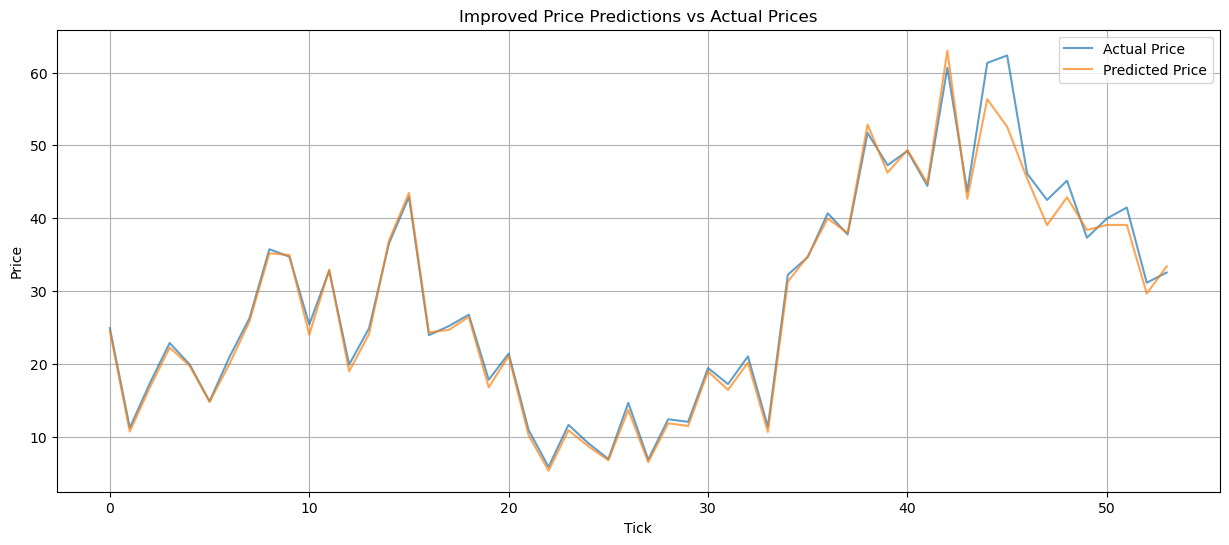

Mean Absolute Error: 1.0185
R² Score: 0.9852


In [75]:
# Add momentum and volatility features
from sklearn.metrics import mean_absolute_error, r2_score

for window in [3, 5, 10]:
    df_nn_enhanced[f'price_momentum_{window}'] = df_nn_enhanced['avg_buy_price'].diff(window)
    df_nn_enhanced[f'price_volatility_{window}'] = df_nn_enhanced['avg_buy_price'].rolling(window).std()
    df_nn_enhanced[f'price_acceleration_{window}'] = df_nn_enhanced[f'price_momentum_{window}'].diff()

# Add price change direction features
df_nn_enhanced['price_direction'] = np.sign(df_nn_enhanced['avg_buy_price'].diff())

# Add rolling mean crossovers
df_nn_enhanced['ma_crossover'] = df_nn_enhanced['buy_ma5'] - df_nn_enhanced['buy_ma20']

class ImprovedNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Initial layer
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        
        # Residual blocks
        self.res1_fc1 = nn.Linear(256, 256)
        self.res1_bn1 = nn.BatchNorm1d(256)
        self.res1_fc2 = nn.Linear(256, 256)
        self.res1_bn2 = nn.BatchNorm1d(256)
        
        self.res2_fc1 = nn.Linear(256, 256)
        self.res2_bn1 = nn.BatchNorm1d(256)
        self.res2_fc2 = nn.Linear(256, 256)
        self.res2_bn2 = nn.BatchNorm1d(256)
        
        # Output layers
        self.fc_out1 = nn.Linear(256, 64)
        self.bn_out1 = nn.BatchNorm1d(64)
        self.fc_out2 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Initial layer
        x = F.relu(self.bn1(self.fc1(x)))
        
        # Residual block 1
        identity = x
        x = F.relu(self.res1_bn1(self.res1_fc1(x)))
        x = self.dropout(x)
        x = self.res1_bn2(self.res1_fc2(x))
        x = F.relu(x + identity)
        
        # Residual block 2
        identity = x
        x = F.relu(self.res2_bn1(self.res2_fc1(x)))
        x = self.dropout(x)
        x = self.res2_bn2(self.res2_fc2(x))
        x = F.relu(x + identity)
        
        # Output layers
        x = F.relu(self.bn_out1(self.fc_out1(x)))
        x = self.fc_out2(x)
        return x

# Prepare data
X_improved = df_nn_enhanced.select_dtypes(include=[np.number]).fillna(0)
y_improved = df_nn_enhanced['avg_buy_price']

# Remove target variables
target_cols = ['target_next_buy', 'target_buy_up', 'target_next_demand', 'target_next_profit']
X_improved = X_improved.drop([col for col in target_cols if col in X_improved.columns], axis=1)

# Scale features
scaler_improved = StandardScaler()
X_improved_scaled = scaler_improved.fit_transform(X_improved)

# Split data with shorter prediction window
train_size = int(len(X_improved_scaled) * 0.8)
X_train = X_improved_scaled[:train_size]
y_train = y_improved[:train_size]
X_test = X_improved_scaled[train_size:]
y_test = y_improved[train_size:]

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Initialize model
model_improved = ImprovedNet(X_train.shape[1])
criterion = nn.HuberLoss()  # More robust to outliers
optimizer = optim.AdamW(model_improved.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=100, steps_per_epoch=1)

# Training loop
best_val_loss = float('inf')
patience = 15
counter = 0

for epoch in range(100):
    model_improved.train()
    optimizer.zero_grad()
    
    outputs = model_improved(X_train_t)
    loss = criterion(outputs, y_train_t)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # Validation
    model_improved.eval()
    with torch.no_grad():
        val_outputs = model_improved(X_test_t)
        val_loss = criterion(val_outputs, y_test_t)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model_improved.state_dict()
            counter = 0
        else:
            counter += 1
            
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

# Load best model
model_improved.load_state_dict(best_state)

# Generate predictions
model_improved.eval()
with torch.no_grad():
    X_full_t = torch.tensor(X_improved_scaled, dtype=torch.float32)
    predictions = model_improved(X_full_t).numpy().flatten()

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(y_improved.values, label='Actual Price', alpha=0.7)
plt.plot(predictions, label='Predicted Price', alpha=0.7)
plt.title('Improved Price Predictions vs Actual Prices')
plt.xlabel('Tick')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(y_improved, predictions):.4f}")
print(f"R² Score: {r2_score(y_improved, predictions):.4f}")

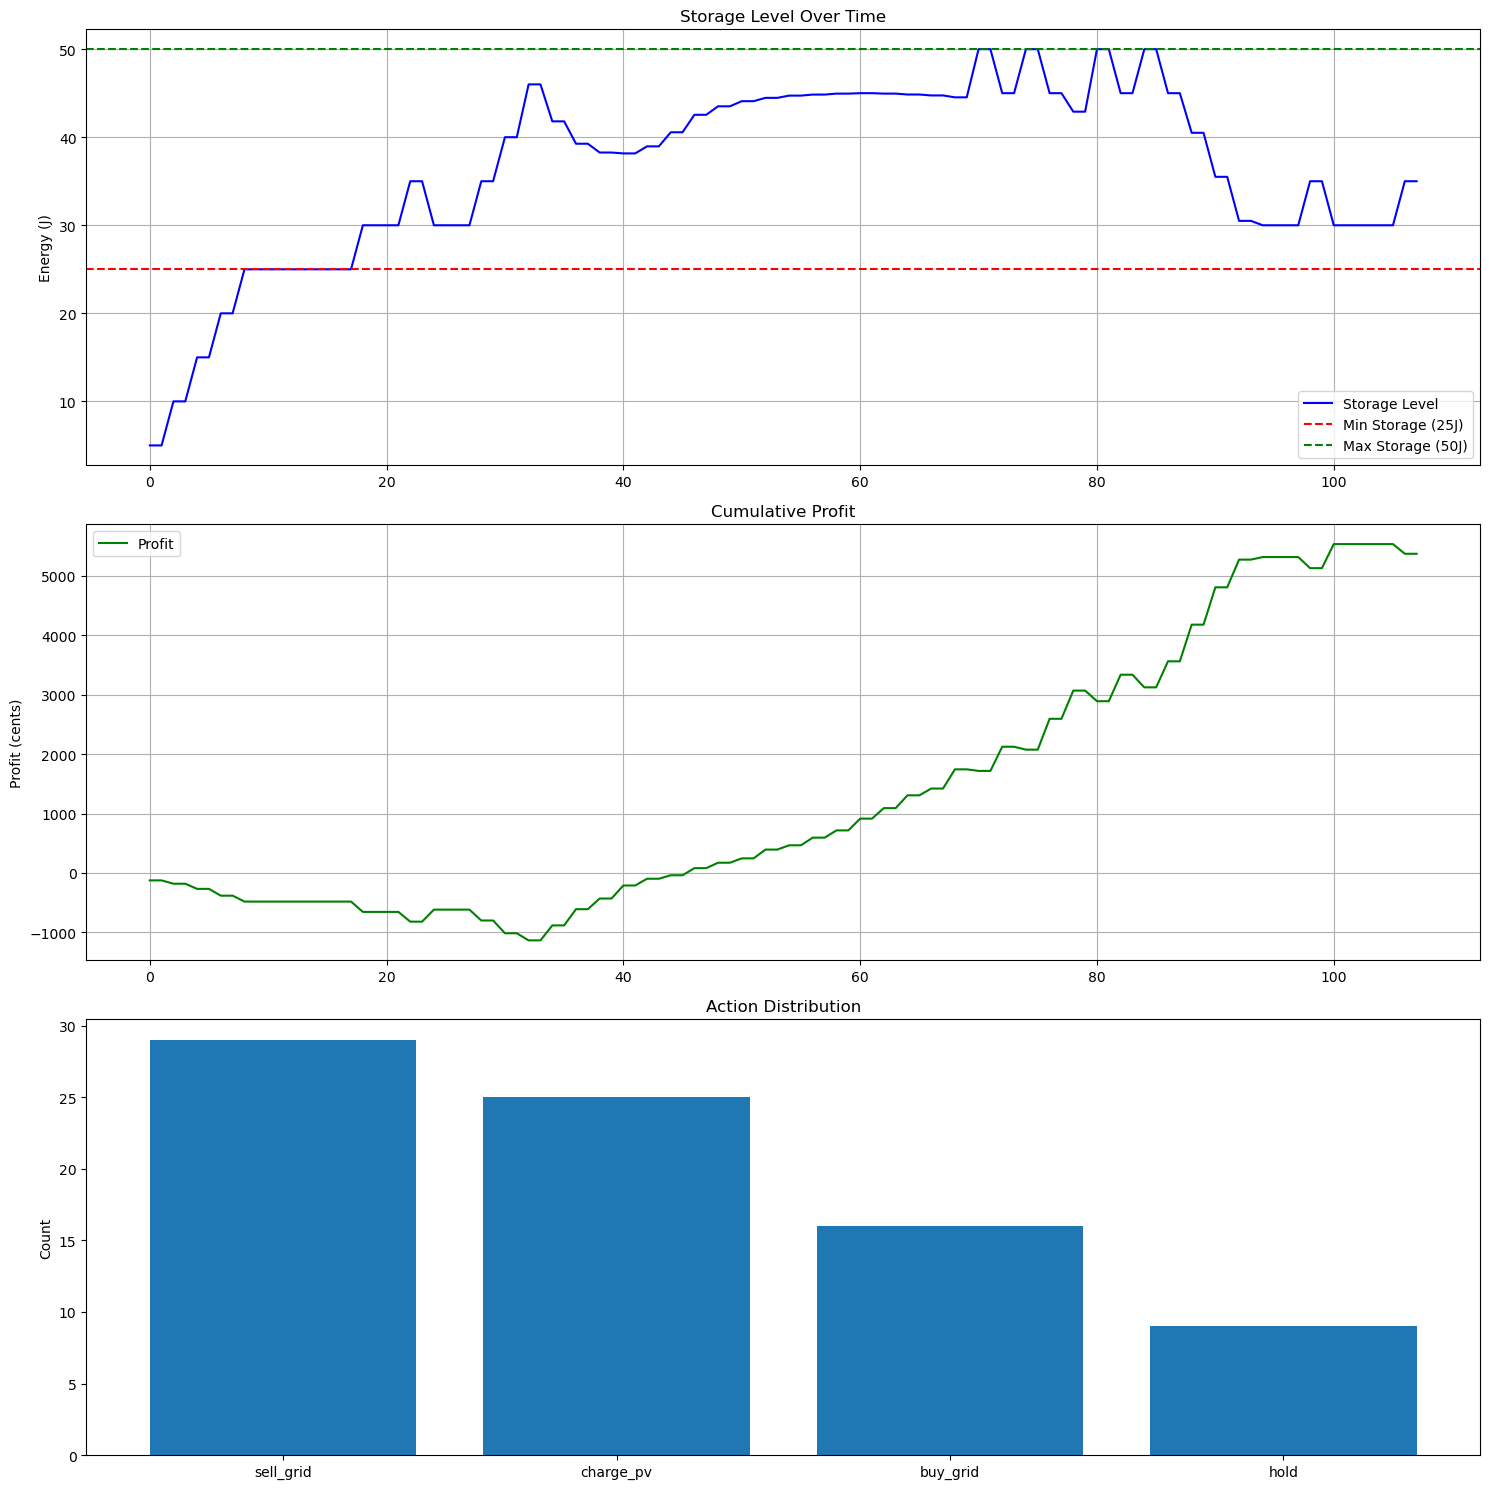

Final profit: 5368.31 cents

Action distribution:
sell_grid: 29 times (36.7%)
charge_pv: 25 times (31.6%)
buy_grid: 16 times (20.3%)
hold: 9 times (11.4%)

Average storage level: 36.49J


In [ ]:
# Improved trading strategy with more aggressive actions
storage = [0]
profit = 0
profit_over_time = []
actions = []
storage_debug = []

# Parameters
min_storage = 25
max_storage = 50
transaction_cost = 0.1
min_profit_threshold = 0.05  # Minimum profit per unit to trigger action

for i in range(len(df_nn_enhanced)):
    current_storage = storage[-1]
    tick = i % 60  # Server uses 60 ticks per day
    price_now = df_nn_enhanced['avg_buy_price'].iloc[i]
    sell_price = df_nn_enhanced['avg_sell_price'].iloc[i]
    next_price = predictions[i]
    
    # Calculate sunlight
    if tick < SUNRISE:
        sun = 0
    elif tick < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((tick-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    
    # Initial charging phase (before reaching min_storage)
    if current_storage < min_storage:
        charge_amount = min(5, min_storage - current_storage)
        if sun > 30:  # Good sunlight
            current_storage += charge_amount
            actions.append('store_solar_energy')
        else:  # Buy from grid
            current_storage += charge_amount
            profit -= charge_amount * price_now
            actions.append('buy_grid')
    
    # Normal operation phase
    else:
        # Always try to use PV charging when available
        if sun > 0 and current_storage < max_storage:
            charge_amount = min((max_storage - current_storage) * sun/100, sun/10)
            current_storage += charge_amount
            actions.append('store_solar_energy')
        
        # Price-based decisions
        price_trend = predictions[i] - price_now
        
        # Buy condition: price is going up and we have capacity
        if price_trend > min_profit_threshold and current_storage < max_storage:
            buy_amount = min(5, max_storage - current_storage)
            current_storage += buy_amount
            profit -= buy_amount * price_now
            actions.append('buy_grid')
        
        # Sell condition: price is good and we have excess storage
        elif current_storage > min_storage + 5:  # Keep some buffer
            # Calculate optimal sell amount
            sell_amount = min(5, current_storage - (min_storage + 5))
            if sell_amount > 0:
                current_storage -= sell_amount
                profit += sell_amount * sell_price
                actions.append('sell_grid')
        else:
            # Hold only if no sun or storage is full
            if sun > 0 and current_storage < max_storage:
                charge_amount = min((max_storage - current_storage) * sun/100, sun/10)
                current_storage += charge_amount
                actions.append('store_solar_energy')
            else:
                actions.append('hold')
    
    # Ensure storage limits
    current_storage = max(0, min(current_storage, max_storage))
    storage.append(current_storage)
    profit_over_time.append(profit)
    
    # Ensure storage limits
    current_storage = max(0, min(current_storage, max_storage))
    storage.append(current_storage)
    profit_over_time.append(profit)

# Remove initial value
storage = storage[1:]

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Plot 1: Storage Level
ax1.plot(storage, label='Storage Level', color='blue')
ax1.axhline(min_storage, color='red', linestyle='--', label='Min Storage (25J)')
ax1.axhline(max_storage, color='green', linestyle='--', label='Max Storage (50J)')
ax1.set_title('Storage Level Over Time')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

# Plot 2: Profit
ax2.plot(profit_over_time, label='Profit', color='green')
ax2.set_title('Cumulative Profit')
ax2.set_ylabel('Profit (cents)')
ax2.legend()
ax2.grid(True)

# Plot 3: Actions
action_counts = pd.Series(actions).value_counts()
ax3.bar(action_counts.index, action_counts.values)
ax3.set_title('Action Distribution')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f"Final profit: {profit_over_time[-1]:.2f} cents")
print("\nAction distribution:")
for action, count in action_counts.items():
    print(f"{action}: {count} times ({count/len(actions)*100:.1f}%)")
print(f"\nAverage storage level: {sum(storage)/len(storage):.2f}J")

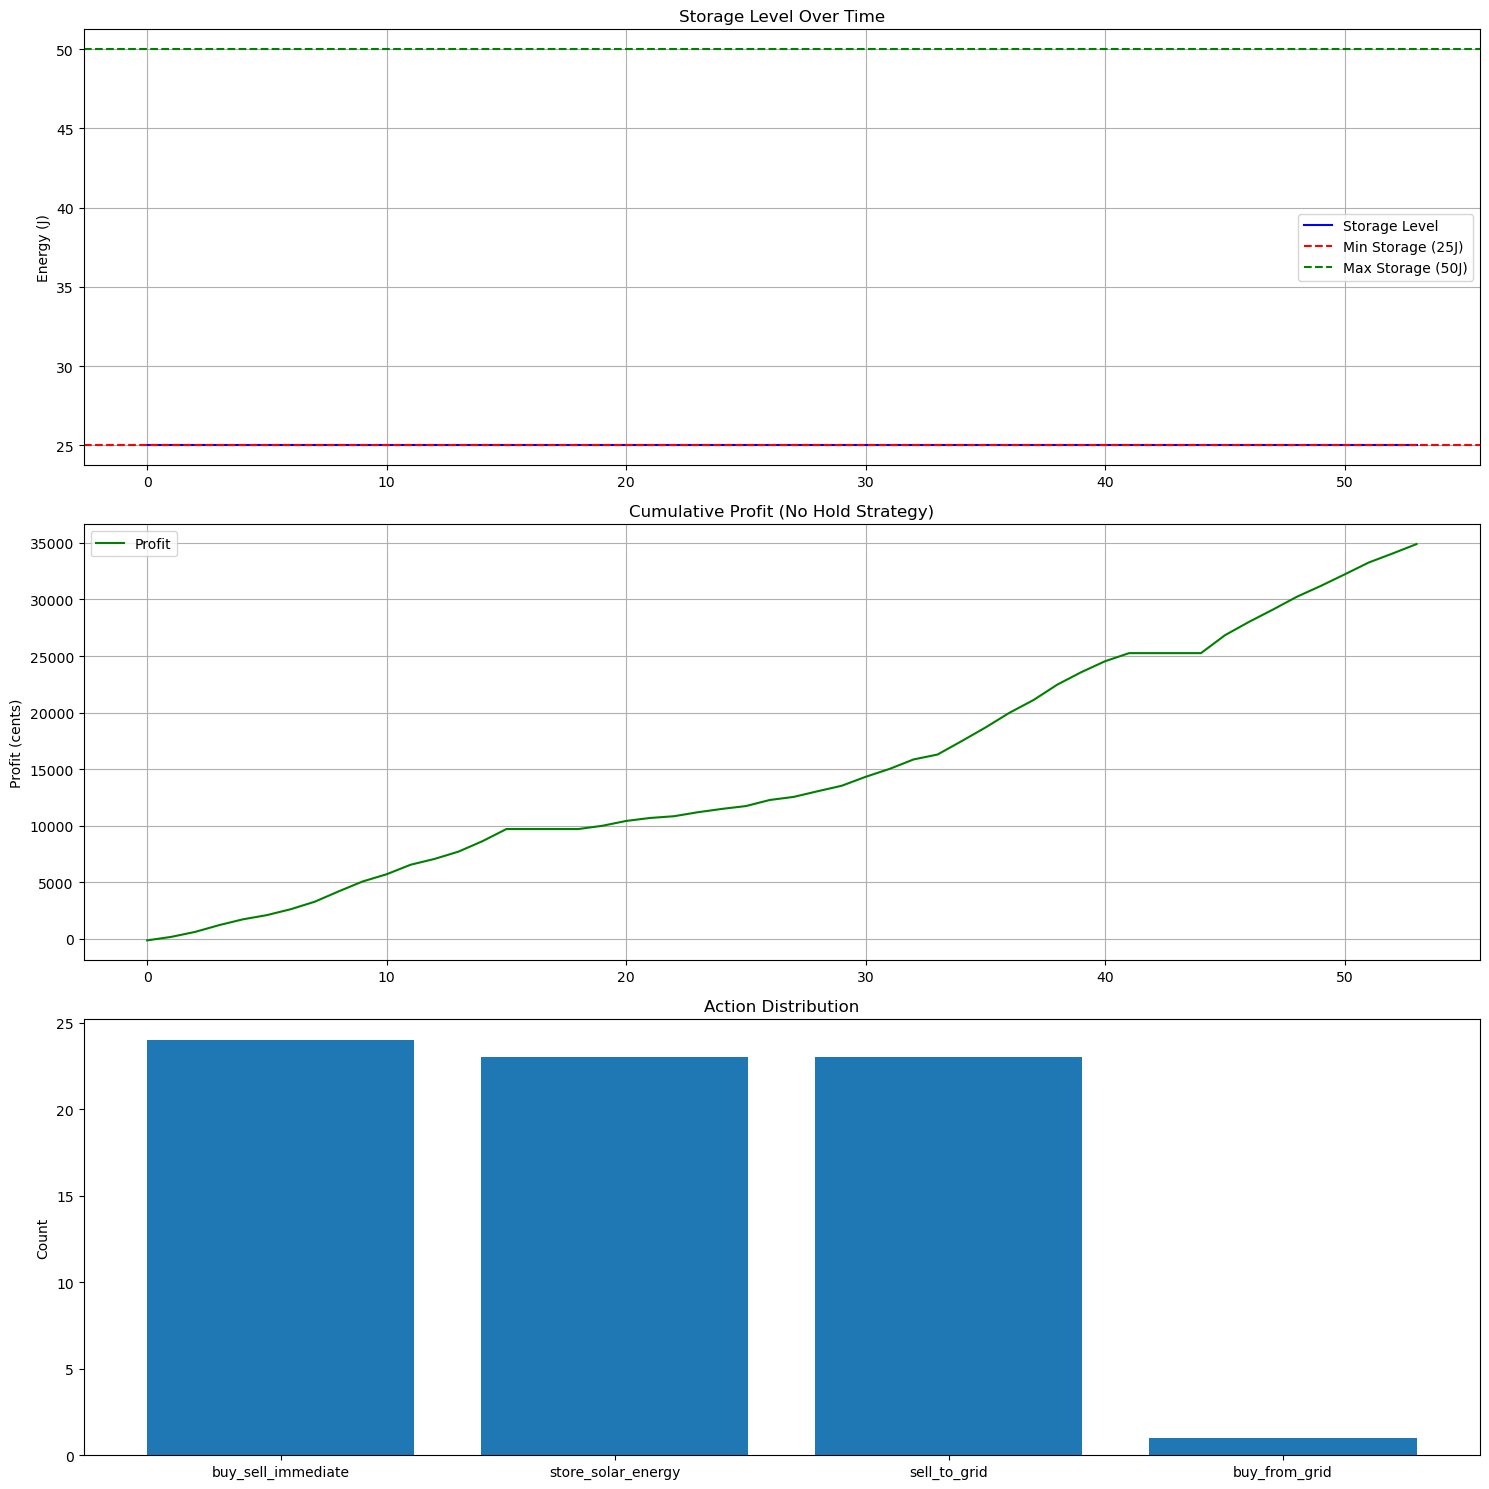


Strategy Performance:
Final profit: 34892.01 cents

Action distribution:
buy_sell_immediate: 24 times (33.8%)
store_solar_energy: 23 times (32.4%)
sell_to_grid: 23 times (32.4%)
buy_from_grid: 1 times (1.4%)

Storage statistics:
Average storage level: 25.00J
Maximum storage: 25.00J
Minimum storage: 25.00J


In [80]:
# Optimized trading strategy without "hold" actions
storage = [0]
profit = 0
profit_over_time = []
actions = []
storage_debug = []

# Parameters
min_storage = 25
max_storage = 50
transaction_cost = 0.1

for i in range(len(df_nn_enhanced)):
    current_storage = storage[-1]
    price_now = df_nn_enhanced['avg_buy_price'].iloc[i]
    sell_price = df_nn_enhanced['avg_sell_price'].iloc[i]
    tick = i % 60
    
    # Calculate sunlight
    if tick < SUNRISE:
        sun = 0
    elif tick < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((tick-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    
    # Priority 1: Store solar energy (it's free!)
    if sun > 30 and current_storage < max_storage:
        charge_amt = min(max_storage - current_storage, sun/5)
        if charge_amt > 0:
            current_storage += charge_amt
            actions.append('store_solar_energy')
            storage_debug.append(('Solar charge', current_storage))
    
    # Priority 2: If below min_storage, buy enough to reach it
    if current_storage < min_storage:
        buy_amt = min(5, min_storage - current_storage)
        profit -= buy_amt * price_now + transaction_cost
        current_storage += buy_amt
        actions.append('buy_from_grid')
        storage_debug.append(('Emergency buy', current_storage))
    
    # Priority 3: If excess storage, sell it
    elif current_storage > min_storage:
        sell_amt = current_storage - min_storage
        profit += sell_amt * sell_price - transaction_cost
        current_storage -= sell_amt
        actions.append('sell_to_grid')
        storage_debug.append(('Sell excess', current_storage))
    
    # Priority 4: If we have space and no sun, do buy-sell arbitrage
    elif current_storage < max_storage and sun == 0:
        space_available = max_storage - current_storage
        # Only if we can make profit after transaction costs
        if (sell_price - price_now) * space_available > transaction_cost * 2:
            buy_amt = space_available
            # Buy and immediately sell
            profit += buy_amt * (sell_price - price_now) - transaction_cost * 2
            actions.append('buy_sell_immediate')
            storage_debug.append(('Buy-sell arbitrage', current_storage))
    
    # Ensure storage limits
    current_storage = max(min_storage, min(current_storage, max_storage))
    storage.append(current_storage)
    profit_over_time.append(profit)

# Remove initial dummy value
storage = storage[1:]

# Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Plot 1: Storage Level
ax1.plot(storage, label='Storage Level', color='blue')
ax1.axhline(min_storage, color='red', linestyle='--', label='Min Storage (25J)')
ax1.axhline(max_storage, color='green', linestyle='--', label='Max Storage (50J)')
ax1.set_title('Storage Level Over Time')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

# Plot 2: Profit
ax2.plot(profit_over_time, label='Profit', color='green')
ax2.set_title('Cumulative Profit (No Hold Strategy)')
ax2.set_ylabel('Profit (cents)')
ax2.legend()
ax2.grid(True)

# Plot 3: Action Distribution
action_counts = pd.Series(actions).value_counts()
ax3.bar(action_counts.index, action_counts.values)
ax3.set_title('Action Distribution')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()

print("\nStrategy Performance:")
print(f"Final profit: {profit_over_time[-1]:.2f} cents")
print("\nAction distribution:")
for action, count in action_counts.items():
    print(f"{action}: {count} times ({count/len(actions)*100:.1f}%)")
print(f"\nStorage statistics:")
print(f"Average storage level: {sum(storage)/len(storage):.2f}J")
print(f"Maximum storage: {max(storage):.2f}J")
print(f"Minimum storage: {min(storage):.2f}J")

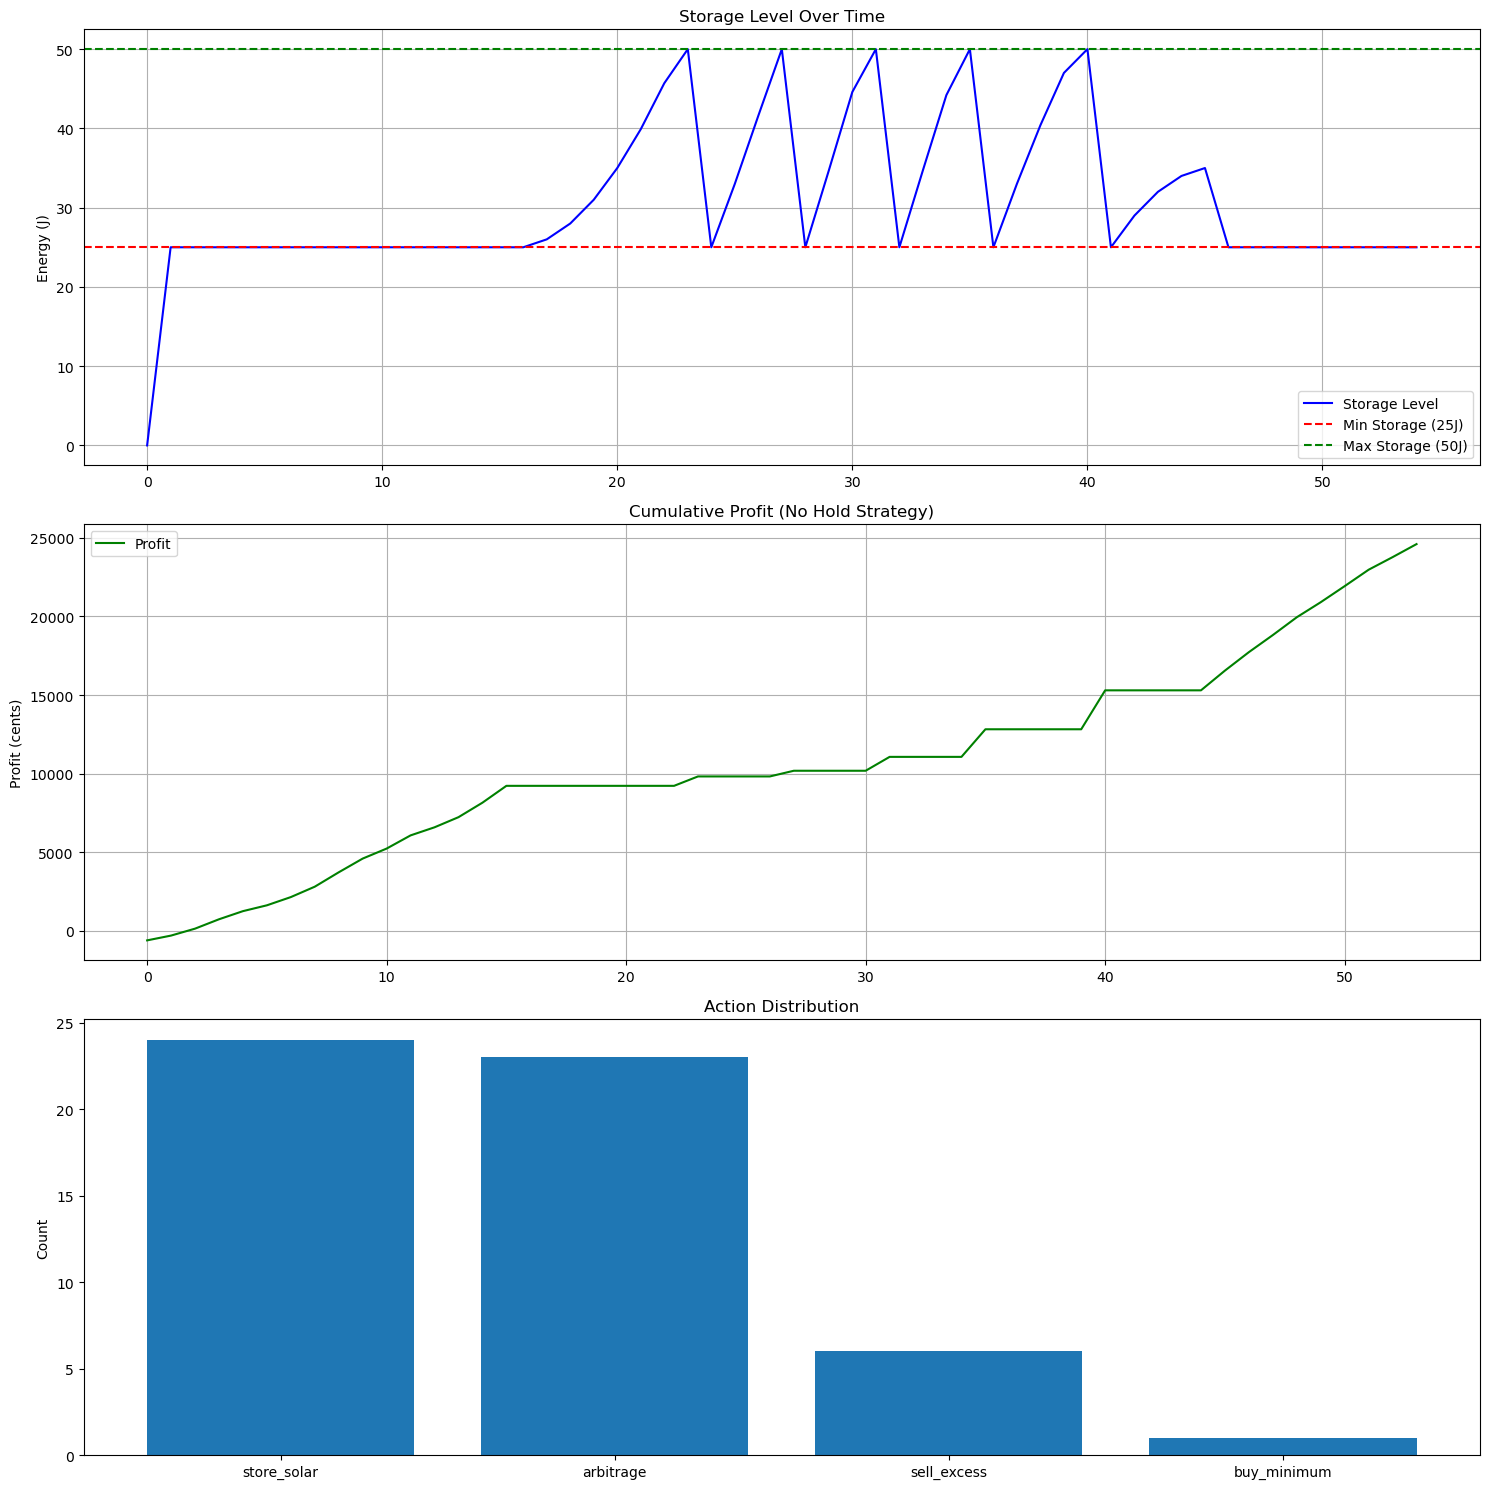


Strategy Performance:
Final profit: 24608.97 cents

Action distribution:
store_solar: 24 times (44.4%)
arbitrage: 23 times (42.6%)
sell_excess: 6 times (11.1%)
buy_minimum: 1 times (1.9%)

Storage statistics:
Average storage level: 30.71J
Maximum storage: 50.00J
Minimum storage: 0.00J


In [84]:
# Simplified optimal trading strategy without neural network
storage = [0]
profit = 0
profit_over_time = []
actions = []

# Parameters
min_storage = 25
max_storage = 50
transaction_cost = 0

for i in range(len(df_nn_enhanced)):
    current_storage = storage[-1]
    price_now = df_nn_enhanced['avg_buy_price'].iloc[i]
    sell_price = df_nn_enhanced['avg_sell_price'].iloc[i]
    tick = i % 60
    
    # Calculate sunlight
    if tick < SUNRISE:
        sun = 0
    elif tick < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((tick-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    
    # Priority 1: Store solar energy (it's free!)
    if sun > 0 and current_storage < max_storage:
        charge_amt = min(max_storage - current_storage, sun/10)
        current_storage += charge_amt
        actions.append('store_solar')
    
    # Priority 2: If above min_storage, sell excess (guaranteed 2x profit)
    elif current_storage > min_storage:
        sell_amt = current_storage - min_storage
        profit += sell_amt * sell_price - transaction_cost
        current_storage -= sell_amt
        actions.append('sell_excess')
    
    # Priority 3: If below min_storage, buy what we need
    elif current_storage < min_storage:
        buy_amt = min_storage - current_storage
        profit -= buy_amt * price_now + transaction_cost
        current_storage += buy_amt
        actions.append('buy_minimum')
    
    # Priority 4: If at min_storage, do buy-sell arbitrage when possible
    elif sun == 0:  # Only if no sun available
        space = max_storage - current_storage
        # Buy and immediately sell if profit > transaction costs
        if space * (sell_price - price_now) > transaction_cost * 2:
            profit += space * (sell_price - price_now) - transaction_cost * 2
            actions.append('arbitrage')
    
    storage.append(current_storage)
    profit_over_time.append(profit)

    # Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Plot 1: Storage Level
ax1.plot(storage, label='Storage Level', color='blue')
ax1.axhline(min_storage, color='red', linestyle='--', label='Min Storage (25J)')
ax1.axhline(max_storage, color='green', linestyle='--', label='Max Storage (50J)')
ax1.set_title('Storage Level Over Time')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

# Plot 2: Profit
ax2.plot(profit_over_time, label='Profit', color='green')
ax2.set_title('Cumulative Profit (No Hold Strategy)')
ax2.set_ylabel('Profit (cents)')
ax2.legend()
ax2.grid(True)

# Plot 3: Action Distribution
action_counts = pd.Series(actions).value_counts()
ax3.bar(action_counts.index, action_counts.values)
ax3.set_title('Action Distribution')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()

print("\nStrategy Performance:")
print(f"Final profit: {profit_over_time[-1]:.2f} cents")
print("\nAction distribution:")
for action, count in action_counts.items():
    print(f"{action}: {count} times ({count/len(actions)*100:.1f}%)")
print(f"\nStorage statistics:")
print(f"Average storage level: {sum(storage)/len(storage):.2f}J")
print(f"Maximum storage: {max(storage):.2f}J")
print(f"Minimum storage: {min(storage):.2f}J")

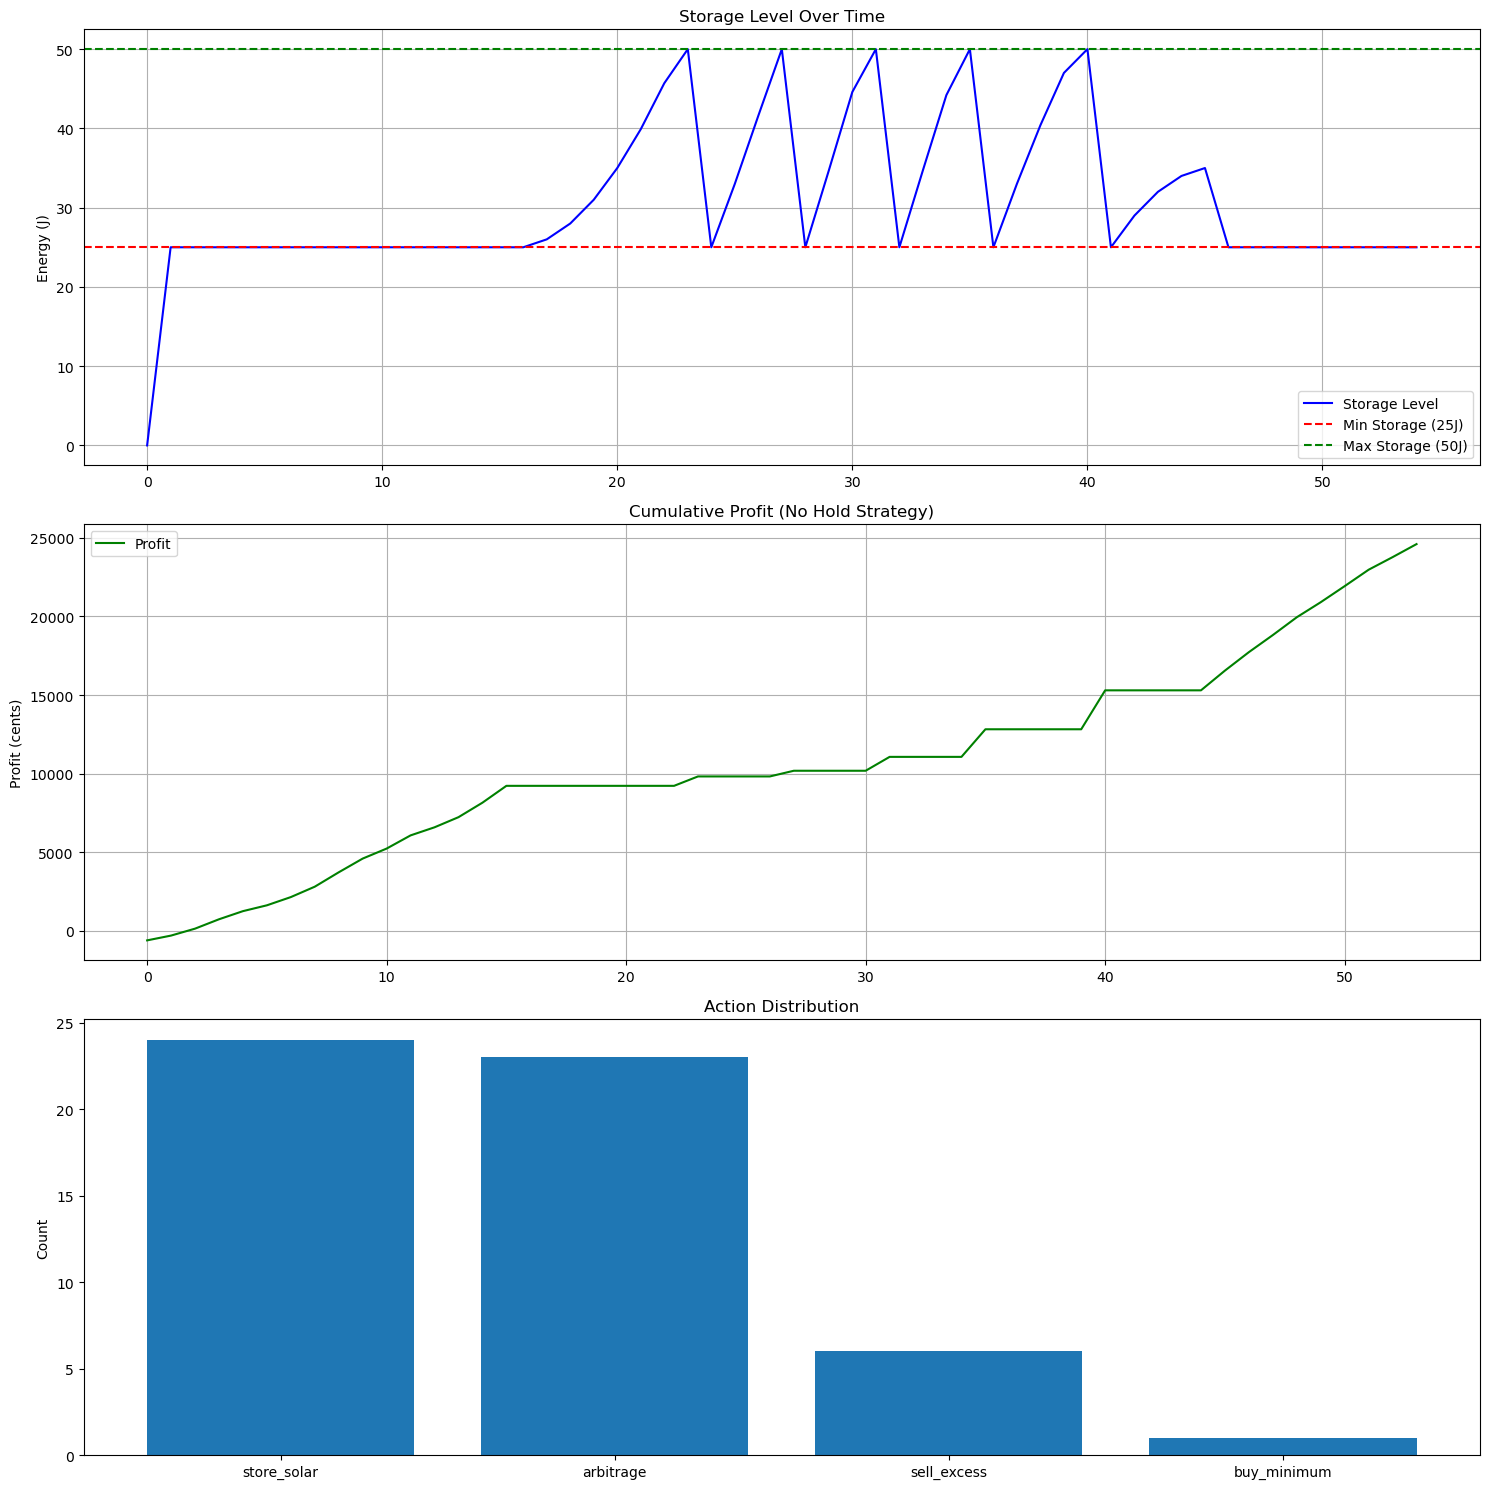


Strategy Performance:
Final profit: 24608.97 cents

Action distribution:
store_solar: 24 times (44.4%)
arbitrage: 23 times (42.6%)
sell_excess: 6 times (11.1%)
buy_minimum: 1 times (1.9%)

Storage statistics:
Average storage level: 30.71J
Maximum storage: 50.00J
Minimum storage: 0.00J


In [ ]:
# Dual prediction neural network
class DualPredictionNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Price prediction branch
        self.price_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
        # Demand prediction branch
        self.demand_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        shared_features = self.shared(x)
        price_pred = self.price_head(shared_features)
        demand_pred = self.demand_head(shared_features)
        return price_pred, demand_pred

# Trading strategy using dual predictions
storage = [0]
profit = 0
profit_over_time = []
actions = []

# Parameters (no transaction costs!)
min_storage = 25
max_storage = 50
transaction_cost = 0  # Set to 0 as specified

for i in range(len(df_nn_enhanced)):
    current_storage = storage[-1]
    price_now = df_nn_enhanced['avg_buy_price'].iloc[i]
    sell_price = df_nn_enhanced['avg_sell_price'].iloc[i]
    tick = i % 60
    
    # Calculate sunlight
    if tick < SUNRISE:
        sun = 0
    elif tick < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((tick-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    
    # Priority 1: Store solar energy (it's free!)
    if sun > 0 and current_storage < max_storage:
        charge_amt = min(max_storage - current_storage, sun/10)
        current_storage += charge_amt
        actions.append('store_solar')
    
    # Priority 2: If above min_storage, sell excess (guaranteed 2x profit)
    # Without transaction costs, we can sell and buy more aggressively
    elif current_storage > min_storage:
        sell_amt = current_storage - min_storage
        profit += sell_amt * sell_price
        current_storage -= sell_amt
        actions.append('sell_excess')
    
    # Priority 3: If below min_storage, buy what we need
    elif current_storage < min_storage:
        buy_amt = min_storage - current_storage
        profit -= buy_amt * price_now
        current_storage += buy_amt
        actions.append('buy_minimum')
    
    # Priority 4: If at min_storage, do buy-sell arbitrage
    # Without transaction costs, we can do arbitrage whenever sell_price > price_now
    elif sun == 0:  # Only if no sun available
        space = max_storage - current_storage
        # Buy and immediately sell (no transaction costs to worry about!)
        if sell_price > price_now:
            profit += space * (sell_price - price_now)
            actions.append('arbitrage')
    
    storage.append(current_storage)
    profit_over_time.append(profit)

  # Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Plot 1: Storage Level
ax1.plot(storage, label='Storage Level', color='blue')
ax1.axhline(min_storage, color='red', linestyle='--', label='Min Storage (25J)')
ax1.axhline(max_storage, color='green', linestyle='--', label='Max Storage (50J)')
ax1.set_title('Storage Level Over Time')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

# Plot 2: Profit
ax2.plot(profit_over_time, label='Profit', color='green')
ax2.set_title('Cumulative Profit (No Hold Strategy)')
ax2.set_ylabel('Profit (cents)')
ax2.legend()
ax2.grid(True)
import os

from flask import (Flask, redirect, render_template, request,
                   send_from_directory, url_for)
import time
import math
import random

SECS_PER_DAY = 300.0
TICKS_PER_DAY = 60
SUNRISE = 15    #Sunrise ticks after start of day
DAY_LENGTH = 30 #Ticks between sunrise and sunset

BASE_DEMAND_PROFILE = [(0,25), (10,25), (20,100), (50,100), (TICKS_PER_DAY,25)] #Piecewise definition of baseline demand
BASE_DEMAND_SCALING = 0.02  #Watts per demand point
DEMAND_RND_VAR = 1.0        #Random variation of instantaneous demand (wWtts)
DEMAND_MIN = 0.0            #Minimum instantaneous demand

BASE_PRICE = 10.0           #Constant price of energy (cents/joule)
PRICE_SOLAR_DEP = 1.0       #Cost of base demand minus sun mismatch (cents/joule/point)
PRICE_RND_VAR = 20.0        #Random variation in prince (cents/joule)
PRICE_MIN = 10              #Minimum price (cents/joule)
BUY_RATIO = 0.5             #Energy buy price as ratio of sell price

DEF_DEMANDS = [ #List of deferrable demands: (start range), (deadline range), (energy range)
    ((0,0), (TICKS_PER_DAY-1,TICKS_PER_DAY-1), (50.0,50.0)),    #Regular, anytime demand
    ((40,50), (TICKS_PER_DAY-1,TICKS_PER_DAY-1), (20.0,40.0)),  #Evening demand with some variation
    ((0,70), (30,TICKS_PER_DAY-1), (10.0,50.0))               #Unpredictable demand
]
MIN_DEMAND_DURATION = 10

app = Flask(__name__)

@app.route('/')
def index():
   print('Request for index page received')
   return render_template('index.html')

@app.route('/favicon.ico')
def favicon():
    return send_from_directory(os.path.join(app.root_path, 'static'),
                               'favicon.ico', mimetype='image/vnd.microsoft.icon')
@app.route("/sun")
def get_sun():
    _,tick = getTick()
    sun = getSunlight(tick)
    return {"tick": tick, "sun": sun}

@app.route("/price")
def get_price():
    day,tick = getTick()
    sell,buy = getPrice(day,tick)
    return {"day": day, "tick": tick, "sell_price": sell, "buy_price": buy}

@app.route("/demand")
def get_demand():
    day,tick = getTick()
    demand = getInstDemand(day,tick)
    return {"day": day, "tick": tick, "demand": demand}

@app.route("/yesterday")
def get_yesterday():
    day,_ = getTick()
    data = []
    for tick in range(TICKS_PER_DAY):
        demand = getInstDemand(day-1,tick)
        sell,buy = getPrice(day-1,tick)
        data.append({"tick": tick, "demand": demand, "sell_price": sell, "buy_price": buy})
    return data

@app.route("/deferables")
def get_deferables():
    day,_ = getTick()
    return getDefDemands(day)

def getTick():
    theTime = time.time()
    day = int(theTime/SECS_PER_DAY)
    tick = int(math.fmod(theTime,SECS_PER_DAY)/SECS_PER_DAY*TICKS_PER_DAY)
    return day,tick


def getSunlight(tick):
    if tick < SUNRISE:
        sun = 0
    elif tick < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((tick-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    return sun

def getBaseDemand(tick):
    lastp = (0,0)
    for p in BASE_DEMAND_PROFILE:
        if tick < p[0]:
            demand = int(float(tick-lastp[0])/(float(p[0]-lastp[0])) * (p[1]-lastp[1]) + lastp[1])
            break
        else:
            lastp = p
    return demand

def getInstDemand(day,tick):
    baseDemand = getBaseDemand(tick)
    random.seed(day*TICKS_PER_DAY+tick)
    instDemand = baseDemand * BASE_DEMAND_SCALING + random.gauss()*DEMAND_RND_VAR
    if instDemand < DEMAND_MIN:
        instDemand = DEMAND_MIN
    return instDemand

def getPrice(day,tick):
    random.seed(day*TICKS_PER_DAY+tick)
    SupplyVsDemand = float(getBaseDemand(tick)-getSunlight(tick))
    sell = int(BASE_PRICE + SupplyVsDemand * PRICE_SOLAR_DEP + random.gauss()*PRICE_RND_VAR)
    if sell < PRICE_MIN:
        sell = PRICE_MIN
    buy = int(sell * BUY_RATIO)
    return sell, buy

def getDefDemands(day):
    random.seed(day)
    data = []
    for d in DEF_DEMANDS:
        start = random.randint(*d[0])
        end = random.randint(*d[1])
        energy = random.uniform(*d[2])
        if end-start < MIN_DEMAND_DURATION:
            if start + MIN_DEMAND_DURATION >= TICKS_PER_DAY:
                start = end - MIN_DEMAND_DURATION
            else:
                end = start + MIN_DEMAND_DURATION
        data.append({"start": start, "end": end, "energy": energy})
    return data


if __name__ == '__main__':
   app.run()
# Plot 3: Action Distribution
action_counts = pd.Series(actions).value_counts()
ax3.bar(action_counts.index, action_counts.values)
ax3.set_title('Action Distribution')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()

print("\nStrategy Performance:")
print(f"Final profit: {profit_over_time[-1]:.2f} cents")
print("\nAction distribution:")
for action, count in action_counts.items():
    print(f"{action}: {count} times ({count/len(actions)*100:.1f}%)")
print(f"\nStorage statistics:")
print(f"Average storage level: {sum(storage)/len(storage):.2f}J")
print(f"Maximum storage: {max(storage):.2f}J")
print(f"Minimum storage: {min(storage):.2f}J")